# Name Generation using RNN
Generating new drug barnd names using GRU network

In [ ]:
import tensorflow as tf
from numpy.random import shuffle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split


##  Data loading

In [ ]:
# for loading data
def load_data(filename):
    with open(filename, 'r') as f:
        data = f.read().lower().split('\n')
    return np.array(data)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = load_data('/content/drive/MyDrive/names.txt')
print('No. of names: ' + str(len(data)))

No. of names: 443


Split data into training and validation set

In [ ]:
# split data
train_data, val_data = train_test_split(data, test_size=0.05)
print(len(train_data))
print(len(val_data))

420
23


## Text Processing


In [ ]:
# find the unique characters for the vocabulary
#  Here '#' means End of Sentence
vocab_tokens = ['#'] + list(set(''.join(data)))
vocab_tokens_len = len(vocab_tokens)
print(vocab_tokens_len)

37


In [ ]:
# find the max length amongst names
max_name_len = max(len(name) for name in train_data)
print('Max length: ', max_name_len)

Max length:  18


In [ ]:
# create vocabulary dict
# character to index
ch_to_idx = {ch:idx for idx, ch in tqdm(enumerate(vocab_tokens))}
print('\nDict len: ', len(ch_to_idx))
print(ch_to_idx)

# index to chracter
idx_to_ch = {ch_to_idx[ch]:ch for ch in ch_to_idx.keys()}
print('\nDict len: ', len(idx_to_ch))
print(idx_to_ch)

37it [00:00, 233016.89it/s]


Dict len:  37
{'#': 0, 'g': 1, 'b': 2, 's': 3, '/': 4, 'f': 5, 'i': 6, 'n': 7, '-': 8, 't': 9, 'd': 10, 'r': 11, '1': 12, '4': 13, 'm': 14, 'k': 15, '2': 16, 'h': 17, '5': 18, 'j': 19, 'y': 20, 'o': 21, 'w': 22, 'q': 23, ' ': 24, 'u': 25, 'z': 26, '&': 27, 'l': 28, 'x': 29, '0': 30, 'a': 31, 'c': 32, '.': 33, 'v': 34, 'e': 35, 'p': 36}

Dict len:  37
{0: '#', 1: 'g', 2: 'b', 3: 's', 4: '/', 5: 'f', 6: 'i', 7: 'n', 8: '-', 9: 't', 10: 'd', 11: 'r', 12: '1', 13: '4', 14: 'm', 15: 'k', 16: '2', 17: 'h', 18: '5', 19: 'j', 20: 'y', 21: 'o', 22: 'w', 23: 'q', 24: ' ', 25: 'u', 26: 'z', 27: '&', 28: 'l', 29: 'x', 30: '0', 31: 'a', 32: 'c', 33: '.', 34: 'v', 35: 'e', 36: 'p'}


In [ ]:
# for converting string names to matrix representation consisting of numerical indices
# output shape: (m, Tx)
def to_num_matrix(names, ch_to_idx):

    max_len = max(map(len, names))
    names_idx = np.zeros((len(names), max_len), dtype='int32')

    for i, name in enumerate(names):
        for j, ch in enumerate(name):
            names_idx[i][j] = ch_to_idx[ch]

    return names_idx

In [ ]:
to_num_matrix(train_data, ch_to_idx).shape

(420, 18)

## Training
This is a simple model using Vanilla Recurrent units.

In [ ]:
from IPython.display import clear_output
from random import sample
import pickle
import sys

In [ ]:
from keras.layers import Embedding, Dense, Concatenate
import keras
import keras.layers as L
from keras.utils import to_categorical
from keras.callbacks import LambdaCallback, ModelCheckpoint
from keras.models import Sequential, load_model

In [ ]:
# for finding the validation accuracy
def compute_acc():
    # convert validation data
    val_x = to_num_matrix(val_data, ch_to_idx)
    # validation labels
    val_y = np.copy(val_x[:,1:])


    # leave the last character
    pred = model.predict(val_x[:,:-1], batch_size=256, verbose=1)
    pred_ch = pred.argmax(axis=-1)

    # find acc
    return float(np.sum(np.logical_and((pred_ch!=0), (pred_ch == val_y)))) \
                / np.sum(val_y != 0)

In [ ]:

# custom callback
def acc_on_epoch_end(epoch, logs):
    sys.stdout.flush()
    print('\nValidation Accuracy: ' + str(compute_acc()*100) + ' %')
    sys.stdout.flush()

In [ ]:
# for generating batches
def generate_model_batches(names, batch_size=32, pad=0):
    # no. of training examples
    m = np.arange(len(names))

    while True:
        # get a shuffled index list
        idx = np.random.permutation(m)

        # start yeilding batches
        for start in range(0, len(idx)-1, batch_size):
            batch_idx = idx[start:start+batch_size]
            batch_words = []

            # take out the words and tags from 'batch_size' no. of training examples
            for index in batch_idx:
                batch_words.append(names[index])

            # input x
            batch_x = to_num_matrix(batch_words, ch_to_idx)

            # output labels
            batch_y_ohe = to_categorical(batch_x[:,1:], len(vocab_tokens))
            yield batch_x[:,:-1], batch_y_ohe

## Model
We will use a simple GRU model.

In [ ]:
acc_callback = LambdaCallback(on_epoch_end=acc_on_epoch_end)
checkpoint = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/best_weights.h5', verbose=1, save_best_only=True)

In [ ]:

model = Sequential()
model.add(L.InputLayer([None], dtype='int32'))
# embeddings layer
model.add(L.Embedding(len(vocab_tokens), 20))

# gru layer
model.add(L.GRU(128, return_sequences=True, activation='tanh'))
model.add(L.Dropout(0.5))
model.add(L.BatchNormalization())

# apply softmax
model.add(L.TimeDistributed(L.Dense(len(vocab_tokens), activation='softmax')))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 20)          740       
                                                                 
 gru (GRU)                   (None, None, 128)         57600     
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 batch_normalization (BatchN  (None, None, 128)        512       
 ormalization)                                                   
                                                                 
 time_distributed (TimeDistr  (None, None, 37)         4773      
 ibuted)                                                         
                                                                 
Total params: 63,625
Trainable params: 63,369
Non-traina

In [ ]:
BATCH_SIZE = 256

# select optimizer
optimizer = keras.optimizers.Adam(clipvalue=1.2)
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# train model
hist = model.fit_generator(generate_model_batches(train_data, batch_size=BATCH_SIZE), steps_per_epoch=len(train_data)/BATCH_SIZE,
                          callbacks=[acc_callback, checkpoint], epochs=1000)

<ipython-input-35-d57eede69c2c>:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(generate_model_batches(train_data, batch_size=BATCH_SIZE), steps_per_epoch=len(train_data)/BATCH_SIZE,


Epoch 1/1000
1/1 [==============================] - 0s 335ms/step

Validation Accuracy: 29.444444444444446 %


1/1 [==============================] - 4s 612ms/step - loss: 1.0406 - accuracy: 0.6755
Epoch 2/1000
1/1 [==============================] - 0s 28ms/step

Validation Accuracy: 24.444444444444443 %


1/1 [==============================] - 0s 138ms/step - loss: 1.0064 - accuracy: 0.6832
Epoch 3/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 25.555555555555554 %


1/1 [==============================] - 0s 122ms/step - loss: 1.0337 - accuracy: 0.6710
Epoch 4/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 30.555555555555557 %


1/1 [==============================] - 0s 130ms/step - loss: 1.0109 - accuracy: 0.6807
Epoch 5/1000
1/1 [==============================] - 0s 23ms/step

Validation Accuracy: 31.11111111111111 %


1/1 [==============================] - 0s 128ms/step - loss: 1.0122 - accuracy: 0.6786
Epoch 6/1000
1/1 [==============================] - 0s 23ms/step

Validation Accuracy: 28.333333333333332 %


1/1 [==============================] - 0s 139ms/step - loss: 1.0068 - accuracy: 0.6828
Epoch 7/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 25.555555555555554 %


1/1 [==============================] - 0s 116ms/step - loss: 1.0016 - accuracy: 0.6772
Epoch 8/1000
1/1 [==============================] - 0s 19ms/step

Validation Accuracy: 25.555555555555554 %


1/1 [==============================] - 0s 112ms/step - loss: 1.0005 - accuracy: 0.6786
Epoch 9/1000
1/1 [==============================] - 0s 25ms/step

Validation Accuracy: 29.444444444444446 %


1/1 [==============================] - 0s 122ms/step - loss: 1.0077 - accuracy: 0.6822
Epoch 10/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 31.11111111111111 %


1/1 [==============================] - 0s 117ms/step - loss: 1.0006 - accuracy: 0.6758
Epoch 11/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 32.22222222222222 %


1/1 [==============================] - 0s 113ms/step - loss: 1.0021 - accuracy: 0.6838
Epoch 12/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 30.555555555555557 %


1/1 [==============================] - 0s 127ms/step - loss: 0.9970 - accuracy: 0.6871
Epoch 13/1000
1/1 [==============================] - 0s 22ms/step

Validation Accuracy: 29.444444444444446 %


1/1 [==============================] - 0s 113ms/step - loss: 0.9956 - accuracy: 0.6863
Epoch 14/1000
1/1 [==============================] - 0s 22ms/step

Validation Accuracy: 27.77777777777778 %


1/1 [==============================] - 0s 124ms/step - loss: 1.0023 - accuracy: 0.6831
Epoch 15/1000
1/1 [==============================] - 0s 23ms/step

Validation Accuracy: 28.888888888888886 %


1/1 [==============================] - 0s 123ms/step - loss: 1.0063 - accuracy: 0.6832
Epoch 16/1000
1/1 [==============================] - 0s 22ms/step

Validation Accuracy: 33.33333333333333 %


1/1 [==============================] - 0s 122ms/step - loss: 0.9990 - accuracy: 0.6801
Epoch 17/1000
1/1 [==============================] - 0s 19ms/step

Validation Accuracy: 32.77777777777778 %


1/1 [==============================] - 0s 116ms/step - loss: 0.9848 - accuracy: 0.6864
Epoch 18/1000
1/1 [==============================] - 0s 19ms/step

Validation Accuracy: 32.77777777777778 %


1/1 [==============================] - 0s 129ms/step - loss: 0.9928 - accuracy: 0.6832
Epoch 19/1000
1/1 [==============================] - 0s 23ms/step

Validation Accuracy: 30.555555555555557 %


1/1 [==============================] - 0s 120ms/step - loss: 0.9951 - accuracy: 0.6839
Epoch 20/1000
1/1 [==============================] - 0s 28ms/step

Validation Accuracy: 31.11111111111111 %


1/1 [==============================] - 0s 141ms/step - loss: 0.9836 - accuracy: 0.6860
Epoch 21/1000
1/1 [==============================] - 0s 22ms/step

Validation Accuracy: 30.0 %


1/1 [==============================] - 0s 119ms/step - loss: 0.9898 - accuracy: 0.6885
Epoch 22/1000
1/1 [==============================] - 0s 26ms/step

Validation Accuracy: 30.555555555555557 %


1/1 [==============================] - 0s 136ms/step - loss: 0.9913 - accuracy: 0.6847
Epoch 23/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 31.11111111111111 %


1/1 [==============================] - 0s 118ms/step - loss: 0.9833 - accuracy: 0.6875
Epoch 24/1000
1/1 [==============================] - 0s 19ms/step

Validation Accuracy: 32.77777777777778 %


1/1 [==============================] - 0s 119ms/step - loss: 0.9906 - accuracy: 0.6850
Epoch 25/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 32.22222222222222 %


1/1 [==============================] - 0s 128ms/step - loss: 0.9908 - accuracy: 0.6864
Epoch 26/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 32.77777777777778 %


1/1 [==============================] - 0s 121ms/step - loss: 0.9868 - accuracy: 0.6873
Epoch 27/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 33.33333333333333 %


1/1 [==============================] - 0s 117ms/step - loss: 0.9852 - accuracy: 0.6908
Epoch 28/1000
1/1 [==============================] - 0s 19ms/step

Validation Accuracy: 33.33333333333333 %


1/1 [==============================] - 0s 120ms/step - loss: 0.9876 - accuracy: 0.6868
Epoch 29/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 33.88888888888889 %


1/1 [==============================] - 0s 123ms/step - loss: 0.9818 - accuracy: 0.6868
Epoch 30/1000
1/1 [==============================] - 0s 23ms/step

Validation Accuracy: 32.77777777777778 %


1/1 [==============================] - 0s 118ms/step - loss: 0.9814 - accuracy: 0.6853
Epoch 31/1000
1/1 [==============================] - 0s 24ms/step

Validation Accuracy: 33.88888888888889 %


1/1 [==============================] - 0s 134ms/step - loss: 0.9883 - accuracy: 0.6850
Epoch 32/1000
1/1 [==============================] - 0s 23ms/step

Validation Accuracy: 34.44444444444444 %


1/1 [==============================] - 0s 118ms/step - loss: 0.9742 - accuracy: 0.6880
Epoch 33/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 34.44444444444444 %


1/1 [==============================] - 0s 139ms/step - loss: 0.9831 - accuracy: 0.6852
Epoch 34/1000
1/1 [==============================] - 0s 19ms/step

Validation Accuracy: 34.44444444444444 %


1/1 [==============================] - 0s 115ms/step - loss: 0.9747 - accuracy: 0.6945
Epoch 35/1000
1/1 [==============================] - 0s 19ms/step

Validation Accuracy: 33.33333333333333 %


1/1 [==============================] - 0s 114ms/step - loss: 0.9767 - accuracy: 0.6882
Epoch 36/1000
1/1 [==============================] - 0s 19ms/step

Validation Accuracy: 30.555555555555557 %


1/1 [==============================] - 0s 111ms/step - loss: 0.9838 - accuracy: 0.6866
Epoch 37/1000
1/1 [==============================] - 0s 19ms/step

Validation Accuracy: 31.11111111111111 %


1/1 [==============================] - 0s 120ms/step - loss: 0.9695 - accuracy: 0.6903
Epoch 38/1000
1/1 [==============================] - 0s 19ms/step

Validation Accuracy: 33.33333333333333 %


1/1 [==============================] - 0s 118ms/step - loss: 0.9743 - accuracy: 0.6877
Epoch 39/1000
1/1 [==============================] - 0s 22ms/step

Validation Accuracy: 33.33333333333333 %


1/1 [==============================] - 0s 120ms/step - loss: 0.9760 - accuracy: 0.6905
Epoch 40/1000
1/1 [==============================] - 0s 24ms/step

Validation Accuracy: 33.33333333333333 %


1/1 [==============================] - 0s 140ms/step - loss: 0.9763 - accuracy: 0.6947
Epoch 41/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 33.33333333333333 %


1/1 [==============================] - 0s 120ms/step - loss: 0.9600 - accuracy: 0.6887
Epoch 42/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 32.77777777777778 %


1/1 [==============================] - 0s 124ms/step - loss: 0.9647 - accuracy: 0.6983
Epoch 43/1000
1/1 [==============================] - 0s 26ms/step

Validation Accuracy: 32.77777777777778 %


1/1 [==============================] - 0s 132ms/step - loss: 0.9699 - accuracy: 0.6968
Epoch 44/1000
1/1 [==============================] - 0s 19ms/step

Validation Accuracy: 33.88888888888889 %


1/1 [==============================] - 0s 120ms/step - loss: 0.9674 - accuracy: 0.6898
Epoch 45/1000
1/1 [==============================] - 0s 22ms/step

Validation Accuracy: 33.33333333333333 %


1/1 [==============================] - 0s 133ms/step - loss: 0.9659 - accuracy: 0.6980
Epoch 46/1000
1/1 [==============================] - 0s 19ms/step

Validation Accuracy: 33.88888888888889 %


1/1 [==============================] - 0s 111ms/step - loss: 0.9797 - accuracy: 0.6909
Epoch 47/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 32.77777777777778 %


1/1 [==============================] - 0s 116ms/step - loss: 0.9681 - accuracy: 0.6922
Epoch 48/1000
1/1 [==============================] - 0s 19ms/step

Validation Accuracy: 32.22222222222222 %


1/1 [==============================] - 0s 114ms/step - loss: 0.9711 - accuracy: 0.6919
Epoch 49/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 32.22222222222222 %


1/1 [==============================] - 0s 141ms/step - loss: 0.9697 - accuracy: 0.6868
Epoch 50/1000
1/1 [==============================] - 0s 23ms/step

Validation Accuracy: 32.77777777777778 %


1/1 [==============================] - 0s 119ms/step - loss: 0.9653 - accuracy: 0.6952
Epoch 51/1000
1/1 [==============================] - 0s 23ms/step

Validation Accuracy: 33.33333333333333 %


1/1 [==============================] - 0s 119ms/step - loss: 0.9609 - accuracy: 0.6955
Epoch 52/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 33.33333333333333 %


1/1 [==============================] - 0s 116ms/step - loss: 0.9655 - accuracy: 0.6924
Epoch 53/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 32.77777777777778 %


1/1 [==============================] - 0s 121ms/step - loss: 0.9689 - accuracy: 0.6936
Epoch 54/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 31.11111111111111 %


1/1 [==============================] - 0s 133ms/step - loss: 0.9660 - accuracy: 0.6943
Epoch 55/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 33.33333333333333 %


1/1 [==============================] - 0s 115ms/step - loss: 0.9591 - accuracy: 0.6940
Epoch 56/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 32.77777777777778 %


1/1 [==============================] - 0s 118ms/step - loss: 0.9664 - accuracy: 0.6930
Epoch 57/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 32.22222222222222 %


1/1 [==============================] - 0s 120ms/step - loss: 0.9556 - accuracy: 0.7014
Epoch 58/1000
1/1 [==============================] - 0s 22ms/step

Validation Accuracy: 31.11111111111111 %


1/1 [==============================] - 0s 132ms/step - loss: 0.9588 - accuracy: 0.6969
Epoch 59/1000
1/1 [==============================] - 0s 22ms/step

Validation Accuracy: 33.33333333333333 %


1/1 [==============================] - 0s 128ms/step - loss: 0.9603 - accuracy: 0.6976
Epoch 60/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 32.77777777777778 %


1/1 [==============================] - 0s 118ms/step - loss: 0.9559 - accuracy: 0.6930
Epoch 61/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 33.88888888888889 %


1/1 [==============================] - 0s 115ms/step - loss: 0.9495 - accuracy: 0.6973
Epoch 62/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 31.666666666666664 %


1/1 [==============================] - 0s 130ms/step - loss: 0.9557 - accuracy: 0.7014
Epoch 63/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 31.11111111111111 %


1/1 [==============================] - 0s 124ms/step - loss: 0.9514 - accuracy: 0.6964
Epoch 64/1000
1/1 [==============================] - 0s 19ms/step

Validation Accuracy: 32.22222222222222 %


1/1 [==============================] - 0s 121ms/step - loss: 0.9494 - accuracy: 0.6948
Epoch 65/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 32.22222222222222 %


1/1 [==============================] - 0s 119ms/step - loss: 0.9576 - accuracy: 0.6912
Epoch 66/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 31.666666666666664 %


1/1 [==============================] - 0s 124ms/step - loss: 0.9539 - accuracy: 0.6959
Epoch 67/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 31.666666666666664 %


1/1 [==============================] - 0s 130ms/step - loss: 0.9503 - accuracy: 0.6978
Epoch 68/1000
1/1 [==============================] - 0s 19ms/step

Validation Accuracy: 33.33333333333333 %


1/1 [==============================] - 0s 119ms/step - loss: 0.9494 - accuracy: 0.7020
Epoch 69/1000
1/1 [==============================] - 0s 23ms/step

Validation Accuracy: 33.33333333333333 %


1/1 [==============================] - 0s 126ms/step - loss: 0.9500 - accuracy: 0.6992
Epoch 70/1000
1/1 [==============================] - 0s 24ms/step

Validation Accuracy: 31.666666666666664 %


1/1 [==============================] - 0s 120ms/step - loss: 0.9377 - accuracy: 0.7029
Epoch 71/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 32.77777777777778 %


1/1 [==============================] - 0s 123ms/step - loss: 0.9504 - accuracy: 0.6979
Epoch 72/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 34.44444444444444 %


1/1 [==============================] - 0s 118ms/step - loss: 0.9361 - accuracy: 0.7035
Epoch 73/1000
1/1 [==============================] - 0s 22ms/step

Validation Accuracy: 33.33333333333333 %


1/1 [==============================] - 0s 122ms/step - loss: 0.9462 - accuracy: 0.7045
Epoch 74/1000
1/1 [==============================] - 0s 22ms/step

Validation Accuracy: 34.44444444444444 %


1/1 [==============================] - 0s 130ms/step - loss: 0.9409 - accuracy: 0.7015
Epoch 75/1000
1/1 [==============================] - 0s 22ms/step

Validation Accuracy: 33.88888888888889 %


1/1 [==============================] - 0s 133ms/step - loss: 0.9380 - accuracy: 0.7015
Epoch 76/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 33.88888888888889 %


1/1 [==============================] - 0s 129ms/step - loss: 0.9462 - accuracy: 0.7003
Epoch 77/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 33.88888888888889 %


1/1 [==============================] - 0s 121ms/step - loss: 0.9335 - accuracy: 0.7020
Epoch 78/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 32.77777777777778 %


1/1 [==============================] - 0s 134ms/step - loss: 0.9430 - accuracy: 0.7064
Epoch 79/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 32.77777777777778 %


1/1 [==============================] - 0s 128ms/step - loss: 0.9392 - accuracy: 0.7011
Epoch 80/1000
1/1 [==============================] - 0s 19ms/step

Validation Accuracy: 32.77777777777778 %


1/1 [==============================] - 0s 118ms/step - loss: 0.9367 - accuracy: 0.7045
Epoch 81/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 33.33333333333333 %


1/1 [==============================] - 0s 121ms/step - loss: 0.9298 - accuracy: 0.7101
Epoch 82/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 32.77777777777778 %


1/1 [==============================] - 0s 116ms/step - loss: 0.9319 - accuracy: 0.7070
Epoch 83/1000
1/1 [==============================] - 0s 19ms/step

Validation Accuracy: 33.33333333333333 %


1/1 [==============================] - 0s 120ms/step - loss: 0.9363 - accuracy: 0.7031
Epoch 84/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 32.22222222222222 %


1/1 [==============================] - 0s 156ms/step - loss: 0.9356 - accuracy: 0.7036
Epoch 85/1000
1/1 [==============================] - 0s 37ms/step

Validation Accuracy: 32.22222222222222 %


1/1 [==============================] - 0s 197ms/step - loss: 0.9363 - accuracy: 0.7039
Epoch 86/1000
1/1 [==============================] - 0s 33ms/step

Validation Accuracy: 32.22222222222222 %


1/1 [==============================] - 0s 170ms/step - loss: 0.9332 - accuracy: 0.7045
Epoch 87/1000
1/1 [==============================] - 0s 28ms/step

Validation Accuracy: 32.77777777777778 %


1/1 [==============================] - 0s 178ms/step - loss: 0.9295 - accuracy: 0.6994
Epoch 88/1000
1/1 [==============================] - 0s 39ms/step

Validation Accuracy: 34.44444444444444 %


1/1 [==============================] - 0s 204ms/step - loss: 0.9237 - accuracy: 0.7069
Epoch 89/1000
1/1 [==============================] - 0s 28ms/step

Validation Accuracy: 34.44444444444444 %


1/1 [==============================] - 0s 166ms/step - loss: 0.9255 - accuracy: 0.7073
Epoch 90/1000
1/1 [==============================] - 0s 38ms/step

Validation Accuracy: 35.0 %


1/1 [==============================] - 0s 178ms/step - loss: 0.9273 - accuracy: 0.7067
Epoch 91/1000
1/1 [==============================] - 0s 31ms/step

Validation Accuracy: 35.0 %


1/1 [==============================] - 0s 182ms/step - loss: 0.9279 - accuracy: 0.7013
Epoch 92/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 35.0 %


1/1 [==============================] - 0s 168ms/step - loss: 0.9190 - accuracy: 0.7036
Epoch 93/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 33.33333333333333 %


1/1 [==============================] - 0s 195ms/step - loss: 0.9248 - accuracy: 0.7069
Epoch 94/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 32.77777777777778 %


1/1 [==============================] - 0s 185ms/step - loss: 0.9207 - accuracy: 0.7052
Epoch 95/1000
1/1 [==============================] - 0s 31ms/step

Validation Accuracy: 33.33333333333333 %


1/1 [==============================] - 0s 192ms/step - loss: 0.9124 - accuracy: 0.7092
Epoch 96/1000
1/1 [==============================] - 0s 27ms/step

Validation Accuracy: 34.44444444444444 %


1/1 [==============================] - 0s 164ms/step - loss: 0.9163 - accuracy: 0.7116
Epoch 97/1000
1/1 [==============================] - 0s 30ms/step

Validation Accuracy: 35.0 %


1/1 [==============================] - 0s 169ms/step - loss: 0.9118 - accuracy: 0.7092
Epoch 98/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 33.88888888888889 %


1/1 [==============================] - 0s 189ms/step - loss: 0.9079 - accuracy: 0.7119
Epoch 99/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 33.88888888888889 %


1/1 [==============================] - 0s 178ms/step - loss: 0.9086 - accuracy: 0.7132
Epoch 100/1000
1/1 [==============================] - 0s 37ms/step

Validation Accuracy: 35.55555555555556 %


1/1 [==============================] - 0s 170ms/step - loss: 0.9038 - accuracy: 0.7136
Epoch 101/1000
1/1 [==============================] - 0s 28ms/step

Validation Accuracy: 35.0 %


1/1 [==============================] - 0s 158ms/step - loss: 0.9087 - accuracy: 0.7105
Epoch 102/1000
1/1 [==============================] - 0s 30ms/step

Validation Accuracy: 35.0 %


1/1 [==============================] - 0s 188ms/step - loss: 0.9051 - accuracy: 0.7144
Epoch 103/1000
1/1 [==============================] - 0s 31ms/step

Validation Accuracy: 35.55555555555556 %


1/1 [==============================] - 0s 204ms/step - loss: 0.9121 - accuracy: 0.7113
Epoch 104/1000
1/1 [==============================] - 0s 32ms/step

Validation Accuracy: 34.44444444444444 %


1/1 [==============================] - 0s 166ms/step - loss: 0.9076 - accuracy: 0.7132
Epoch 105/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 34.44444444444444 %


1/1 [==============================] - 0s 183ms/step - loss: 0.9042 - accuracy: 0.7146
Epoch 106/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 35.55555555555556 %


1/1 [==============================] - 0s 152ms/step - loss: 0.9088 - accuracy: 0.7112
Epoch 107/1000
1/1 [==============================] - 0s 28ms/step

Validation Accuracy: 35.0 %


1/1 [==============================] - 0s 175ms/step - loss: 0.9038 - accuracy: 0.7091
Epoch 108/1000
1/1 [==============================] - 0s 33ms/step

Validation Accuracy: 34.44444444444444 %


1/1 [==============================] - 0s 160ms/step - loss: 0.8945 - accuracy: 0.7150
Epoch 109/1000
1/1 [==============================] - 0s 30ms/step

Validation Accuracy: 34.44444444444444 %


1/1 [==============================] - 0s 156ms/step - loss: 0.9042 - accuracy: 0.7105
Epoch 110/1000
1/1 [==============================] - 0s 34ms/step

Validation Accuracy: 32.77777777777778 %


1/1 [==============================] - 0s 164ms/step - loss: 0.9008 - accuracy: 0.7115
Epoch 111/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 34.44444444444444 %


1/1 [==============================] - 0s 173ms/step - loss: 0.8970 - accuracy: 0.7137
Epoch 112/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 35.0 %


1/1 [==============================] - 0s 202ms/step - loss: 0.8995 - accuracy: 0.7141
Epoch 113/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 35.0 %


1/1 [==============================] - 0s 186ms/step - loss: 0.9001 - accuracy: 0.7136
Epoch 114/1000
1/1 [==============================] - 0s 30ms/step

Validation Accuracy: 35.55555555555556 %


1/1 [==============================] - 0s 165ms/step - loss: 0.8929 - accuracy: 0.7125
Epoch 115/1000
1/1 [==============================] - 0s 33ms/step

Validation Accuracy: 33.88888888888889 %


1/1 [==============================] - 0s 171ms/step - loss: 0.8984 - accuracy: 0.7127
Epoch 116/1000
1/1 [==============================] - 0s 22ms/step

Validation Accuracy: 34.44444444444444 %


1/1 [==============================] - 0s 147ms/step - loss: 0.8870 - accuracy: 0.7207
Epoch 117/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 36.11111111111111 %


1/1 [==============================] - 0s 128ms/step - loss: 0.8993 - accuracy: 0.7136
Epoch 118/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 35.55555555555556 %


1/1 [==============================] - 0s 126ms/step - loss: 0.8896 - accuracy: 0.7203
Epoch 119/1000
1/1 [==============================] - 0s 24ms/step

Validation Accuracy: 34.44444444444444 %


1/1 [==============================] - 0s 129ms/step - loss: 0.8907 - accuracy: 0.7207
Epoch 120/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 35.55555555555556 %


1/1 [==============================] - 0s 123ms/step - loss: 0.8992 - accuracy: 0.7125
Epoch 121/1000
1/1 [==============================] - 0s 22ms/step

Validation Accuracy: 35.0 %


1/1 [==============================] - 0s 136ms/step - loss: 0.8864 - accuracy: 0.7209
Epoch 122/1000
1/1 [==============================] - 0s 19ms/step

Validation Accuracy: 36.11111111111111 %


1/1 [==============================] - 0s 124ms/step - loss: 0.8782 - accuracy: 0.7195
Epoch 123/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 35.55555555555556 %


1/1 [==============================] - 0s 134ms/step - loss: 0.8852 - accuracy: 0.7167
Epoch 124/1000
1/1 [==============================] - 0s 19ms/step

Validation Accuracy: 34.44444444444444 %


1/1 [==============================] - 0s 125ms/step - loss: 0.8814 - accuracy: 0.7199
Epoch 125/1000
1/1 [==============================] - 0s 22ms/step

Validation Accuracy: 34.44444444444444 %


1/1 [==============================] - 0s 123ms/step - loss: 0.8833 - accuracy: 0.7168
Epoch 126/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 35.0 %


1/1 [==============================] - 0s 128ms/step - loss: 0.8773 - accuracy: 0.7188
Epoch 127/1000
1/1 [==============================] - 0s 19ms/step

Validation Accuracy: 33.88888888888889 %


1/1 [==============================] - 0s 126ms/step - loss: 0.8697 - accuracy: 0.7238
Epoch 128/1000
1/1 [==============================] - 0s 23ms/step

Validation Accuracy: 33.33333333333333 %


1/1 [==============================] - 0s 130ms/step - loss: 0.8796 - accuracy: 0.7181
Epoch 129/1000
1/1 [==============================] - 0s 22ms/step

Validation Accuracy: 35.0 %


1/1 [==============================] - 0s 129ms/step - loss: 0.8826 - accuracy: 0.7207
Epoch 130/1000
1/1 [==============================] - 0s 25ms/step

Validation Accuracy: 35.0 %


1/1 [==============================] - 0s 151ms/step - loss: 0.8822 - accuracy: 0.7193
Epoch 131/1000
1/1 [==============================] - 0s 22ms/step

Validation Accuracy: 34.44444444444444 %


1/1 [==============================] - 0s 129ms/step - loss: 0.8752 - accuracy: 0.7203
Epoch 132/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 34.44444444444444 %


1/1 [==============================] - 0s 135ms/step - loss: 0.8736 - accuracy: 0.7207
Epoch 133/1000
1/1 [==============================] - 0s 19ms/step

Validation Accuracy: 35.55555555555556 %


1/1 [==============================] - 0s 122ms/step - loss: 0.8810 - accuracy: 0.7200
Epoch 134/1000
1/1 [==============================] - 0s 22ms/step

Validation Accuracy: 35.55555555555556 %


1/1 [==============================] - 0s 123ms/step - loss: 0.8706 - accuracy: 0.7270
Epoch 135/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 34.44444444444444 %


1/1 [==============================] - 0s 121ms/step - loss: 0.8649 - accuracy: 0.7261
Epoch 136/1000
1/1 [==============================] - 0s 23ms/step

Validation Accuracy: 34.44444444444444 %


1/1 [==============================] - 0s 137ms/step - loss: 0.8671 - accuracy: 0.7199
Epoch 137/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 35.55555555555556 %


1/1 [==============================] - 0s 137ms/step - loss: 0.8658 - accuracy: 0.7206
Epoch 138/1000
1/1 [==============================] - 0s 22ms/step

Validation Accuracy: 35.0 %


1/1 [==============================] - 0s 125ms/step - loss: 0.8736 - accuracy: 0.7221
Epoch 139/1000
1/1 [==============================] - 0s 19ms/step

Validation Accuracy: 34.44444444444444 %


1/1 [==============================] - 0s 128ms/step - loss: 0.8587 - accuracy: 0.7290
Epoch 140/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 34.44444444444444 %


1/1 [==============================] - 0s 118ms/step - loss: 0.8624 - accuracy: 0.7269
Epoch 141/1000
1/1 [==============================] - 0s 23ms/step

Validation Accuracy: 35.0 %


1/1 [==============================] - 0s 127ms/step - loss: 0.8550 - accuracy: 0.7311
Epoch 142/1000
1/1 [==============================] - 0s 18ms/step

Validation Accuracy: 34.44444444444444 %


1/1 [==============================] - 0s 118ms/step - loss: 0.8582 - accuracy: 0.7252
Epoch 143/1000
1/1 [==============================] - 0s 19ms/step

Validation Accuracy: 34.44444444444444 %


1/1 [==============================] - 0s 122ms/step - loss: 0.8685 - accuracy: 0.7255
Epoch 144/1000
1/1 [==============================] - 0s 19ms/step

Validation Accuracy: 34.44444444444444 %


1/1 [==============================] - 0s 123ms/step - loss: 0.8525 - accuracy: 0.7256
Epoch 145/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 33.88888888888889 %


1/1 [==============================] - 0s 123ms/step - loss: 0.8446 - accuracy: 0.7303
Epoch 146/1000
1/1 [==============================] - 0s 19ms/step

Validation Accuracy: 33.88888888888889 %


1/1 [==============================] - 0s 136ms/step - loss: 0.8552 - accuracy: 0.7249
Epoch 147/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 33.33333333333333 %


1/1 [==============================] - 0s 134ms/step - loss: 0.8674 - accuracy: 0.7197
Epoch 148/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 33.33333333333333 %


1/1 [==============================] - 0s 125ms/step - loss: 0.8518 - accuracy: 0.7269
Epoch 149/1000
1/1 [==============================] - 0s 19ms/step

Validation Accuracy: 34.44444444444444 %


1/1 [==============================] - 0s 124ms/step - loss: 0.8631 - accuracy: 0.7289
Epoch 150/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 35.0 %


1/1 [==============================] - 0s 125ms/step - loss: 0.8439 - accuracy: 0.7296
Epoch 151/1000
1/1 [==============================] - 0s 19ms/step

Validation Accuracy: 33.33333333333333 %


1/1 [==============================] - 0s 123ms/step - loss: 0.8529 - accuracy: 0.7310
Epoch 152/1000
1/1 [==============================] - 0s 22ms/step

Validation Accuracy: 33.88888888888889 %


1/1 [==============================] - 0s 138ms/step - loss: 0.8466 - accuracy: 0.7303
Epoch 153/1000
1/1 [==============================] - 0s 19ms/step

Validation Accuracy: 33.88888888888889 %


1/1 [==============================] - 0s 122ms/step - loss: 0.8372 - accuracy: 0.7342
Epoch 154/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 33.88888888888889 %


1/1 [==============================] - 0s 124ms/step - loss: 0.8447 - accuracy: 0.7272
Epoch 155/1000
1/1 [==============================] - 0s 19ms/step

Validation Accuracy: 36.11111111111111 %


1/1 [==============================] - 0s 123ms/step - loss: 0.8370 - accuracy: 0.7357
Epoch 156/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 33.88888888888889 %


1/1 [==============================] - 0s 139ms/step - loss: 0.8378 - accuracy: 0.7349
Epoch 157/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 35.0 %


1/1 [==============================] - 0s 146ms/step - loss: 0.8546 - accuracy: 0.7241
Epoch 158/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 34.44444444444444 %


1/1 [==============================] - 0s 128ms/step - loss: 0.8407 - accuracy: 0.7329
Epoch 159/1000
1/1 [==============================] - 0s 23ms/step

Validation Accuracy: 33.33333333333333 %


1/1 [==============================] - 0s 124ms/step - loss: 0.8409 - accuracy: 0.7345
Epoch 160/1000
1/1 [==============================] - 0s 26ms/step

Validation Accuracy: 33.33333333333333 %


1/1 [==============================] - 0s 140ms/step - loss: 0.8339 - accuracy: 0.7359
Epoch 161/1000
1/1 [==============================] - 0s 19ms/step

Validation Accuracy: 33.33333333333333 %


1/1 [==============================] - 0s 120ms/step - loss: 0.8382 - accuracy: 0.7312
Epoch 162/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 33.33333333333333 %


1/1 [==============================] - 0s 122ms/step - loss: 0.8371 - accuracy: 0.7322
Epoch 163/1000
1/1 [==============================] - 0s 22ms/step

Validation Accuracy: 34.44444444444444 %


1/1 [==============================] - 0s 130ms/step - loss: 0.8300 - accuracy: 0.7349
Epoch 164/1000
1/1 [==============================] - 0s 24ms/step

Validation Accuracy: 33.33333333333333 %


1/1 [==============================] - 0s 132ms/step - loss: 0.8351 - accuracy: 0.7352
Epoch 165/1000
1/1 [==============================] - 0s 19ms/step

Validation Accuracy: 33.88888888888889 %


1/1 [==============================] - 0s 121ms/step - loss: 0.8300 - accuracy: 0.7333
Epoch 166/1000
1/1 [==============================] - 0s 22ms/step

Validation Accuracy: 34.44444444444444 %


1/1 [==============================] - 0s 143ms/step - loss: 0.8297 - accuracy: 0.7359
Epoch 167/1000
1/1 [==============================] - 0s 22ms/step

Validation Accuracy: 34.44444444444444 %


1/1 [==============================] - 0s 136ms/step - loss: 0.8217 - accuracy: 0.7366
Epoch 168/1000
1/1 [==============================] - 0s 24ms/step

Validation Accuracy: 33.88888888888889 %


1/1 [==============================] - 0s 129ms/step - loss: 0.8273 - accuracy: 0.7391
Epoch 169/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 33.88888888888889 %


1/1 [==============================] - 0s 132ms/step - loss: 0.8246 - accuracy: 0.7431
Epoch 170/1000
1/1 [==============================] - 0s 19ms/step

Validation Accuracy: 34.44444444444444 %


1/1 [==============================] - 0s 123ms/step - loss: 0.8295 - accuracy: 0.7343
Epoch 171/1000
1/1 [==============================] - 0s 19ms/step

Validation Accuracy: 35.0 %


1/1 [==============================] - 0s 119ms/step - loss: 0.8232 - accuracy: 0.7368
Epoch 172/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 34.44444444444444 %


1/1 [==============================] - 0s 134ms/step - loss: 0.8226 - accuracy: 0.7431
Epoch 173/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 33.33333333333333 %


1/1 [==============================] - 0s 122ms/step - loss: 0.8208 - accuracy: 0.7422
Epoch 174/1000
1/1 [==============================] - 0s 19ms/step

Validation Accuracy: 34.44444444444444 %


1/1 [==============================] - 0s 119ms/step - loss: 0.8151 - accuracy: 0.7384
Epoch 175/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 35.0 %


1/1 [==============================] - 0s 147ms/step - loss: 0.8201 - accuracy: 0.7412
Epoch 176/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 35.0 %


1/1 [==============================] - 0s 123ms/step - loss: 0.8222 - accuracy: 0.7333
Epoch 177/1000
1/1 [==============================] - 0s 24ms/step

Validation Accuracy: 34.44444444444444 %


1/1 [==============================] - 0s 141ms/step - loss: 0.8155 - accuracy: 0.7392
Epoch 178/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 34.44444444444444 %


1/1 [==============================] - 0s 133ms/step - loss: 0.8148 - accuracy: 0.7409
Epoch 179/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 35.55555555555556 %


1/1 [==============================] - 0s 128ms/step - loss: 0.8157 - accuracy: 0.7375
Epoch 180/1000
1/1 [==============================] - 0s 22ms/step

Validation Accuracy: 34.44444444444444 %


1/1 [==============================] - 0s 130ms/step - loss: 0.8118 - accuracy: 0.7389
Epoch 181/1000
1/1 [==============================] - 0s 18ms/step

Validation Accuracy: 34.44444444444444 %


1/1 [==============================] - 0s 114ms/step - loss: 0.8106 - accuracy: 0.7395
Epoch 182/1000
1/1 [==============================] - 0s 19ms/step

Validation Accuracy: 36.11111111111111 %


1/1 [==============================] - 0s 124ms/step - loss: 0.8050 - accuracy: 0.7436
Epoch 183/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 37.22222222222222 %


1/1 [==============================] - 0s 161ms/step - loss: 0.8020 - accuracy: 0.7417
Epoch 184/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 35.0 %


1/1 [==============================] - 0s 131ms/step - loss: 0.8042 - accuracy: 0.7410
Epoch 185/1000
1/1 [==============================] - 0s 22ms/step

Validation Accuracy: 35.55555555555556 %


1/1 [==============================] - 0s 121ms/step - loss: 0.8012 - accuracy: 0.7454
Epoch 186/1000
1/1 [==============================] - 0s 18ms/step

Validation Accuracy: 36.11111111111111 %


1/1 [==============================] - 0s 124ms/step - loss: 0.7989 - accuracy: 0.7468
Epoch 187/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 35.55555555555556 %


1/1 [==============================] - 0s 145ms/step - loss: 0.7944 - accuracy: 0.7471
Epoch 188/1000
1/1 [==============================] - 0s 24ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 145ms/step - loss: 0.8004 - accuracy: 0.7493
Epoch 189/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 34.44444444444444 %


1/1 [==============================] - 0s 132ms/step - loss: 0.8011 - accuracy: 0.7468
Epoch 190/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 33.88888888888889 %


1/1 [==============================] - 0s 141ms/step - loss: 0.8037 - accuracy: 0.7388
Epoch 191/1000
1/1 [==============================] - 0s 22ms/step

Validation Accuracy: 35.0 %


1/1 [==============================] - 0s 133ms/step - loss: 0.7991 - accuracy: 0.7437
Epoch 192/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 33.88888888888889 %


1/1 [==============================] - 0s 134ms/step - loss: 0.7980 - accuracy: 0.7480
Epoch 193/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 33.88888888888889 %


1/1 [==============================] - 0s 128ms/step - loss: 0.7907 - accuracy: 0.7472
Epoch 194/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 35.0 %


1/1 [==============================] - 0s 123ms/step - loss: 0.7887 - accuracy: 0.7511
Epoch 195/1000
1/1 [==============================] - 0s 22ms/step

Validation Accuracy: 34.44444444444444 %


1/1 [==============================] - 0s 131ms/step - loss: 0.7947 - accuracy: 0.7489
Epoch 196/1000
1/1 [==============================] - 0s 26ms/step

Validation Accuracy: 35.0 %


1/1 [==============================] - 0s 129ms/step - loss: 0.7925 - accuracy: 0.7465
Epoch 197/1000
1/1 [==============================] - 0s 19ms/step

Validation Accuracy: 35.0 %


1/1 [==============================] - 0s 122ms/step - loss: 0.7936 - accuracy: 0.7455
Epoch 198/1000
1/1 [==============================] - 0s 19ms/step

Validation Accuracy: 34.44444444444444 %


1/1 [==============================] - 0s 132ms/step - loss: 0.7878 - accuracy: 0.7475
Epoch 199/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 33.88888888888889 %


1/1 [==============================] - 0s 131ms/step - loss: 0.7804 - accuracy: 0.7513
Epoch 200/1000
1/1 [==============================] - 0s 19ms/step

Validation Accuracy: 33.88888888888889 %


1/1 [==============================] - 0s 129ms/step - loss: 0.7796 - accuracy: 0.7527
Epoch 201/1000
1/1 [==============================] - 0s 28ms/step

Validation Accuracy: 34.44444444444444 %


1/1 [==============================] - 0s 146ms/step - loss: 0.7793 - accuracy: 0.7574
Epoch 202/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 34.44444444444444 %


1/1 [==============================] - 0s 148ms/step - loss: 0.7737 - accuracy: 0.7535
Epoch 203/1000
1/1 [==============================] - 0s 22ms/step

Validation Accuracy: 35.0 %


1/1 [==============================] - 0s 127ms/step - loss: 0.7840 - accuracy: 0.7479
Epoch 204/1000
1/1 [==============================] - 0s 22ms/step

Validation Accuracy: 35.0 %


1/1 [==============================] - 0s 132ms/step - loss: 0.7809 - accuracy: 0.7506
Epoch 205/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 33.88888888888889 %


1/1 [==============================] - 0s 120ms/step - loss: 0.7721 - accuracy: 0.7562
Epoch 206/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 34.44444444444444 %


1/1 [==============================] - 0s 141ms/step - loss: 0.7827 - accuracy: 0.7465
Epoch 207/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 36.666666666666664 %


1/1 [==============================] - 0s 145ms/step - loss: 0.7823 - accuracy: 0.7480
Epoch 208/1000
1/1 [==============================] - 0s 22ms/step

Validation Accuracy: 35.0 %


1/1 [==============================] - 0s 132ms/step - loss: 0.7785 - accuracy: 0.7506
Epoch 209/1000
1/1 [==============================] - 0s 19ms/step

Validation Accuracy: 35.0 %


1/1 [==============================] - 0s 122ms/step - loss: 0.7661 - accuracy: 0.7492
Epoch 210/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 36.11111111111111 %


1/1 [==============================] - 0s 127ms/step - loss: 0.7645 - accuracy: 0.7541
Epoch 211/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 36.666666666666664 %


1/1 [==============================] - 0s 131ms/step - loss: 0.7759 - accuracy: 0.7527
Epoch 212/1000
1/1 [==============================] - 0s 19ms/step

Validation Accuracy: 35.55555555555556 %


1/1 [==============================] - 0s 122ms/step - loss: 0.7825 - accuracy: 0.7524
Epoch 213/1000
1/1 [==============================] - 0s 35ms/step

Validation Accuracy: 36.11111111111111 %


1/1 [==============================] - 0s 178ms/step - loss: 0.7716 - accuracy: 0.7539
Epoch 214/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 36.11111111111111 %


1/1 [==============================] - 0s 151ms/step - loss: 0.7728 - accuracy: 0.7525
Epoch 215/1000
1/1 [==============================] - 0s 35ms/step

Validation Accuracy: 35.55555555555556 %


1/1 [==============================] - 0s 185ms/step - loss: 0.7712 - accuracy: 0.7587
Epoch 216/1000
1/1 [==============================] - 0s 31ms/step

Validation Accuracy: 36.666666666666664 %


1/1 [==============================] - 0s 184ms/step - loss: 0.7697 - accuracy: 0.7552
Epoch 217/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 35.55555555555556 %


1/1 [==============================] - 0s 156ms/step - loss: 0.7664 - accuracy: 0.7578
Epoch 218/1000
1/1 [==============================] - 0s 30ms/step

Validation Accuracy: 36.11111111111111 %


1/1 [==============================] - 0s 150ms/step - loss: 0.7689 - accuracy: 0.7508
Epoch 219/1000
1/1 [==============================] - 0s 30ms/step

Validation Accuracy: 35.0 %


1/1 [==============================] - 0s 163ms/step - loss: 0.7549 - accuracy: 0.7563
Epoch 220/1000
1/1 [==============================] - 0s 30ms/step

Validation Accuracy: 33.88888888888889 %


1/1 [==============================] - 0s 155ms/step - loss: 0.7683 - accuracy: 0.7556
Epoch 221/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 34.44444444444444 %


1/1 [==============================] - 0s 148ms/step - loss: 0.7534 - accuracy: 0.7613
Epoch 222/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 34.44444444444444 %


1/1 [==============================] - 0s 148ms/step - loss: 0.7621 - accuracy: 0.7563
Epoch 223/1000
1/1 [==============================] - 0s 31ms/step

Validation Accuracy: 33.33333333333333 %


1/1 [==============================] - 0s 148ms/step - loss: 0.7536 - accuracy: 0.7553
Epoch 224/1000
1/1 [==============================] - 0s 32ms/step

Validation Accuracy: 36.11111111111111 %


1/1 [==============================] - 0s 176ms/step - loss: 0.7545 - accuracy: 0.7630
Epoch 225/1000
1/1 [==============================] - 0s 28ms/step

Validation Accuracy: 35.0 %


1/1 [==============================] - 0s 148ms/step - loss: 0.7629 - accuracy: 0.7553
Epoch 226/1000
1/1 [==============================] - 0s 30ms/step

Validation Accuracy: 33.88888888888889 %


1/1 [==============================] - 0s 154ms/step - loss: 0.7521 - accuracy: 0.7560
Epoch 227/1000
1/1 [==============================] - 0s 30ms/step

Validation Accuracy: 35.0 %


1/1 [==============================] - 0s 148ms/step - loss: 0.7566 - accuracy: 0.7594
Epoch 228/1000
1/1 [==============================] - 0s 32ms/step

Validation Accuracy: 36.666666666666664 %


1/1 [==============================] - 0s 194ms/step - loss: 0.7515 - accuracy: 0.7605
Epoch 229/1000
1/1 [==============================] - 0s 30ms/step

Validation Accuracy: 36.11111111111111 %


1/1 [==============================] - 0s 176ms/step - loss: 0.7472 - accuracy: 0.7633
Epoch 230/1000
1/1 [==============================] - 0s 32ms/step

Validation Accuracy: 36.11111111111111 %


1/1 [==============================] - 0s 191ms/step - loss: 0.7572 - accuracy: 0.7587
Epoch 231/1000
1/1 [==============================] - 0s 31ms/step

Validation Accuracy: 36.11111111111111 %


1/1 [==============================] - 0s 221ms/step - loss: 0.7411 - accuracy: 0.7669
Epoch 232/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 36.666666666666664 %


1/1 [==============================] - 0s 211ms/step - loss: 0.7475 - accuracy: 0.7602
Epoch 233/1000
1/1 [==============================] - 0s 32ms/step

Validation Accuracy: 36.11111111111111 %


1/1 [==============================] - 0s 181ms/step - loss: 0.7462 - accuracy: 0.7587
Epoch 234/1000
1/1 [==============================] - 0s 34ms/step

Validation Accuracy: 35.0 %


1/1 [==============================] - 0s 190ms/step - loss: 0.7400 - accuracy: 0.7615
Epoch 235/1000
1/1 [==============================] - 0s 28ms/step

Validation Accuracy: 36.666666666666664 %


1/1 [==============================] - 0s 185ms/step - loss: 0.7391 - accuracy: 0.7626
Epoch 236/1000
1/1 [==============================] - 0s 28ms/step

Validation Accuracy: 36.11111111111111 %


1/1 [==============================] - 0s 171ms/step - loss: 0.7449 - accuracy: 0.7609
Epoch 237/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 35.55555555555556 %


1/1 [==============================] - 0s 162ms/step - loss: 0.7407 - accuracy: 0.7623
Epoch 238/1000
1/1 [==============================] - 0s 37ms/step

Validation Accuracy: 36.666666666666664 %


1/1 [==============================] - 0s 159ms/step - loss: 0.7388 - accuracy: 0.7606
Epoch 239/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 36.666666666666664 %


1/1 [==============================] - 0s 143ms/step - loss: 0.7364 - accuracy: 0.7643
Epoch 240/1000
1/1 [==============================] - 0s 37ms/step

Validation Accuracy: 35.55555555555556 %


1/1 [==============================] - 0s 167ms/step - loss: 0.7384 - accuracy: 0.7664
Epoch 241/1000
1/1 [==============================] - 0s 31ms/step

Validation Accuracy: 36.11111111111111 %


1/1 [==============================] - 0s 205ms/step - loss: 0.7459 - accuracy: 0.7590
Epoch 242/1000
1/1 [==============================] - 0s 32ms/step

Validation Accuracy: 36.11111111111111 %


1/1 [==============================] - 0s 208ms/step - loss: 0.7281 - accuracy: 0.7706
Epoch 243/1000
1/1 [==============================] - 0s 31ms/step

Validation Accuracy: 34.44444444444444 %


1/1 [==============================] - 0s 187ms/step - loss: 0.7241 - accuracy: 0.7702
Epoch 244/1000
1/1 [==============================] - 0s 27ms/step

Validation Accuracy: 36.11111111111111 %


1/1 [==============================] - 0s 200ms/step - loss: 0.7293 - accuracy: 0.7640
Epoch 245/1000
1/1 [==============================] - 0s 28ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 181ms/step - loss: 0.7349 - accuracy: 0.7685
Epoch 246/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 36.11111111111111 %


1/1 [==============================] - 0s 174ms/step - loss: 0.7309 - accuracy: 0.7646
Epoch 247/1000
1/1 [==============================] - 0s 41ms/step

Validation Accuracy: 36.11111111111111 %


1/1 [==============================] - 0s 197ms/step - loss: 0.7256 - accuracy: 0.7668
Epoch 248/1000
1/1 [==============================] - 0s 30ms/step

Validation Accuracy: 37.22222222222222 %


1/1 [==============================] - 0s 198ms/step - loss: 0.7177 - accuracy: 0.7702
Epoch 249/1000
1/1 [==============================] - 0s 30ms/step

Validation Accuracy: 36.11111111111111 %


1/1 [==============================] - 0s 192ms/step - loss: 0.7222 - accuracy: 0.7660
Epoch 250/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 35.55555555555556 %


1/1 [==============================] - 0s 179ms/step - loss: 0.7211 - accuracy: 0.7727
Epoch 251/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 36.666666666666664 %


1/1 [==============================] - 0s 184ms/step - loss: 0.7238 - accuracy: 0.7664
Epoch 252/1000
1/1 [==============================] - 0s 33ms/step

Validation Accuracy: 35.0 %


1/1 [==============================] - 0s 168ms/step - loss: 0.7290 - accuracy: 0.7669
Epoch 253/1000
1/1 [==============================] - 0s 31ms/step

Validation Accuracy: 36.11111111111111 %


1/1 [==============================] - 0s 167ms/step - loss: 0.7195 - accuracy: 0.7669
Epoch 254/1000
1/1 [==============================] - 0s 24ms/step

Validation Accuracy: 36.666666666666664 %


1/1 [==============================] - 0s 172ms/step - loss: 0.7127 - accuracy: 0.7723
Epoch 255/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 36.11111111111111 %


1/1 [==============================] - 0s 134ms/step - loss: 0.7221 - accuracy: 0.7688
Epoch 256/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 35.55555555555556 %


1/1 [==============================] - 0s 139ms/step - loss: 0.7119 - accuracy: 0.7761
Epoch 257/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 35.0 %


1/1 [==============================] - 0s 134ms/step - loss: 0.7244 - accuracy: 0.7690
Epoch 258/1000
1/1 [==============================] - 0s 22ms/step

Validation Accuracy: 35.0 %


1/1 [==============================] - 0s 140ms/step - loss: 0.7122 - accuracy: 0.7754
Epoch 259/1000
1/1 [==============================] - 0s 19ms/step

Validation Accuracy: 36.11111111111111 %


1/1 [==============================] - 0s 133ms/step - loss: 0.7140 - accuracy: 0.7676
Epoch 260/1000
1/1 [==============================] - 0s 24ms/step

Validation Accuracy: 35.55555555555556 %


1/1 [==============================] - 0s 130ms/step - loss: 0.7001 - accuracy: 0.7723
Epoch 261/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 36.11111111111111 %


1/1 [==============================] - 0s 124ms/step - loss: 0.7054 - accuracy: 0.7769
Epoch 262/1000
1/1 [==============================] - 0s 19ms/step

Validation Accuracy: 36.666666666666664 %


1/1 [==============================] - 0s 133ms/step - loss: 0.7091 - accuracy: 0.7690
Epoch 263/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 36.666666666666664 %


1/1 [==============================] - 0s 132ms/step - loss: 0.7048 - accuracy: 0.7718
Epoch 264/1000
1/1 [==============================] - 0s 23ms/step

Validation Accuracy: 36.666666666666664 %


1/1 [==============================] - 0s 123ms/step - loss: 0.7009 - accuracy: 0.7720
Epoch 265/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 37.22222222222222 %


1/1 [==============================] - 0s 129ms/step - loss: 0.6952 - accuracy: 0.7765
Epoch 266/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 149ms/step - loss: 0.7032 - accuracy: 0.7711
Epoch 267/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 37.22222222222222 %


1/1 [==============================] - 0s 134ms/step - loss: 0.7067 - accuracy: 0.7746
Epoch 268/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 127ms/step - loss: 0.7045 - accuracy: 0.7716
Epoch 269/1000
1/1 [==============================] - 0s 26ms/step

Validation Accuracy: 37.22222222222222 %


1/1 [==============================] - 0s 130ms/step - loss: 0.6977 - accuracy: 0.7790
Epoch 270/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 36.666666666666664 %


1/1 [==============================] - 0s 135ms/step - loss: 0.6948 - accuracy: 0.7755
Epoch 271/1000
1/1 [==============================] - 0s 22ms/step

Validation Accuracy: 36.666666666666664 %


1/1 [==============================] - 0s 128ms/step - loss: 0.7008 - accuracy: 0.7751
Epoch 272/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 37.22222222222222 %


1/1 [==============================] - 0s 162ms/step - loss: 0.6969 - accuracy: 0.7787
Epoch 273/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 131ms/step - loss: 0.6943 - accuracy: 0.7791
Epoch 274/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 139ms/step - loss: 0.6933 - accuracy: 0.7749
Epoch 275/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 159ms/step - loss: 0.6928 - accuracy: 0.7790
Epoch 276/1000
1/1 [==============================] - 0s 22ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 133ms/step - loss: 0.6919 - accuracy: 0.7817
Epoch 277/1000
1/1 [==============================] - 0s 24ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 147ms/step - loss: 0.6953 - accuracy: 0.7777
Epoch 278/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 137ms/step - loss: 0.6894 - accuracy: 0.7797
Epoch 279/1000
1/1 [==============================] - 0s 19ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 127ms/step - loss: 0.6887 - accuracy: 0.7811
Epoch 280/1000
1/1 [==============================] - 0s 19ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 136ms/step - loss: 0.6984 - accuracy: 0.7775
Epoch 281/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 129ms/step - loss: 0.6853 - accuracy: 0.7803
Epoch 282/1000
1/1 [==============================] - 0s 26ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 157ms/step - loss: 0.6804 - accuracy: 0.7786
Epoch 283/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 137ms/step - loss: 0.6912 - accuracy: 0.7786
Epoch 284/1000
1/1 [==============================] - 0s 24ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 122ms/step - loss: 0.6887 - accuracy: 0.7800
Epoch 285/1000
1/1 [==============================] - 0s 22ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 156ms/step - loss: 0.6648 - accuracy: 0.7853
Epoch 286/1000
1/1 [==============================] - 0s 19ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 130ms/step - loss: 0.6789 - accuracy: 0.7845
Epoch 287/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 37.22222222222222 %


1/1 [==============================] - 0s 133ms/step - loss: 0.6737 - accuracy: 0.7818
Epoch 288/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 142ms/step - loss: 0.6809 - accuracy: 0.7770
Epoch 289/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 125ms/step - loss: 0.6770 - accuracy: 0.7800
Epoch 290/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 149ms/step - loss: 0.6790 - accuracy: 0.7793
Epoch 291/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 140ms/step - loss: 0.6744 - accuracy: 0.7808
Epoch 292/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 37.22222222222222 %


1/1 [==============================] - 0s 146ms/step - loss: 0.6675 - accuracy: 0.7857
Epoch 293/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 37.22222222222222 %


1/1 [==============================] - 0s 139ms/step - loss: 0.6726 - accuracy: 0.7807
Epoch 294/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 36.666666666666664 %


1/1 [==============================] - 0s 139ms/step - loss: 0.6688 - accuracy: 0.7840
Epoch 295/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 36.11111111111111 %


1/1 [==============================] - 0s 126ms/step - loss: 0.6765 - accuracy: 0.7874
Epoch 296/1000
1/1 [==============================] - 0s 22ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 141ms/step - loss: 0.6726 - accuracy: 0.7808
Epoch 297/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 165ms/step - loss: 0.6738 - accuracy: 0.7857
Epoch 298/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 134ms/step - loss: 0.6658 - accuracy: 0.7887
Epoch 299/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 136ms/step - loss: 0.6662 - accuracy: 0.7870
Epoch 300/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 137ms/step - loss: 0.6583 - accuracy: 0.7922
Epoch 301/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 127ms/step - loss: 0.6527 - accuracy: 0.7873
Epoch 302/1000
1/1 [==============================] - 0s 22ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 150ms/step - loss: 0.6575 - accuracy: 0.7881
Epoch 303/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 146ms/step - loss: 0.6646 - accuracy: 0.7850
Epoch 304/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 132ms/step - loss: 0.6543 - accuracy: 0.7909
Epoch 305/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 37.22222222222222 %


1/1 [==============================] - 0s 135ms/step - loss: 0.6526 - accuracy: 0.7908
Epoch 306/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 36.666666666666664 %


1/1 [==============================] - 0s 137ms/step - loss: 0.6672 - accuracy: 0.7818
Epoch 307/1000
1/1 [==============================] - 0s 22ms/step

Validation Accuracy: 37.22222222222222 %


1/1 [==============================] - 0s 142ms/step - loss: 0.6616 - accuracy: 0.7895
Epoch 308/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 37.22222222222222 %


1/1 [==============================] - 0s 143ms/step - loss: 0.6504 - accuracy: 0.7877
Epoch 309/1000
1/1 [==============================] - 0s 22ms/step

Validation Accuracy: 36.666666666666664 %


1/1 [==============================] - 0s 138ms/step - loss: 0.6523 - accuracy: 0.7923
Epoch 310/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 37.22222222222222 %


1/1 [==============================] - 0s 145ms/step - loss: 0.6449 - accuracy: 0.7947
Epoch 311/1000
1/1 [==============================] - 0s 22ms/step

Validation Accuracy: 37.22222222222222 %


1/1 [==============================] - 0s 145ms/step - loss: 0.6508 - accuracy: 0.7931
Epoch 312/1000
1/1 [==============================] - 0s 25ms/step

Validation Accuracy: 37.22222222222222 %


1/1 [==============================] - 0s 144ms/step - loss: 0.6449 - accuracy: 0.7906
Epoch 313/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 37.22222222222222 %


1/1 [==============================] - 0s 147ms/step - loss: 0.6497 - accuracy: 0.7895
Epoch 314/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 138ms/step - loss: 0.6424 - accuracy: 0.7908
Epoch 315/1000
1/1 [==============================] - 0s 19ms/step

Validation Accuracy: 36.666666666666664 %


1/1 [==============================] - 0s 139ms/step - loss: 0.6401 - accuracy: 0.7919
Epoch 316/1000
1/1 [==============================] - 0s 22ms/step

Validation Accuracy: 37.22222222222222 %


1/1 [==============================] - 0s 138ms/step - loss: 0.6440 - accuracy: 0.7934
Epoch 317/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 159ms/step - loss: 0.6455 - accuracy: 0.7933
Epoch 318/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 139ms/step - loss: 0.6406 - accuracy: 0.7920
Epoch 319/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 37.22222222222222 %


1/1 [==============================] - 0s 137ms/step - loss: 0.6406 - accuracy: 0.7938
Epoch 320/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 37.22222222222222 %


1/1 [==============================] - 0s 124ms/step - loss: 0.6373 - accuracy: 0.7938
Epoch 321/1000
1/1 [==============================] - 0s 23ms/step

Validation Accuracy: 37.22222222222222 %


1/1 [==============================] - 0s 154ms/step - loss: 0.6339 - accuracy: 0.7964
Epoch 322/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 146ms/step - loss: 0.6379 - accuracy: 0.7895
Epoch 323/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 132ms/step - loss: 0.6408 - accuracy: 0.7961
Epoch 324/1000
1/1 [==============================] - 0s 19ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 130ms/step - loss: 0.6419 - accuracy: 0.7901
Epoch 325/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 121ms/step - loss: 0.6399 - accuracy: 0.7971
Epoch 326/1000
1/1 [==============================] - 0s 22ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 151ms/step - loss: 0.6357 - accuracy: 0.7955
Epoch 327/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 133ms/step - loss: 0.6474 - accuracy: 0.7941
Epoch 328/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 142ms/step - loss: 0.6385 - accuracy: 0.7972
Epoch 329/1000
1/1 [==============================] - 0s 24ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 146ms/step - loss: 0.6422 - accuracy: 0.7906
Epoch 330/1000
1/1 [==============================] - 0s 22ms/step

Validation Accuracy: 37.22222222222222 %


1/1 [==============================] - 0s 143ms/step - loss: 0.6429 - accuracy: 0.7868
Epoch 331/1000
1/1 [==============================] - 0s 31ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 151ms/step - loss: 0.6461 - accuracy: 0.7927
Epoch 332/1000
1/1 [==============================] - 0s 19ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 125ms/step - loss: 0.6361 - accuracy: 0.7938
Epoch 333/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 143ms/step - loss: 0.6287 - accuracy: 0.7965
Epoch 334/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 151ms/step - loss: 0.6381 - accuracy: 0.7959
Epoch 335/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 36.666666666666664 %


1/1 [==============================] - 0s 144ms/step - loss: 0.6247 - accuracy: 0.8020
Epoch 336/1000
1/1 [==============================] - 0s 23ms/step

Validation Accuracy: 36.666666666666664 %


1/1 [==============================] - 0s 141ms/step - loss: 0.6273 - accuracy: 0.7961
Epoch 337/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 36.666666666666664 %


1/1 [==============================] - 0s 132ms/step - loss: 0.6298 - accuracy: 0.7950
Epoch 338/1000
1/1 [==============================] - 0s 24ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 154ms/step - loss: 0.6217 - accuracy: 0.7983
Epoch 339/1000
1/1 [==============================] - 0s 19ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 135ms/step - loss: 0.6273 - accuracy: 0.7992
Epoch 340/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 129ms/step - loss: 0.6232 - accuracy: 0.7975
Epoch 341/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 150ms/step - loss: 0.6365 - accuracy: 0.7975
Epoch 342/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 138ms/step - loss: 0.6289 - accuracy: 0.7944
Epoch 343/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 132ms/step - loss: 0.6298 - accuracy: 0.7950
Epoch 344/1000
1/1 [==============================] - 0s 24ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 149ms/step - loss: 0.6142 - accuracy: 0.8013
Epoch 345/1000
1/1 [==============================] - 0s 35ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 167ms/step - loss: 0.6248 - accuracy: 0.8017
Epoch 346/1000
1/1 [==============================] - 0s 33ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 179ms/step - loss: 0.6174 - accuracy: 0.8028
Epoch 347/1000
1/1 [==============================] - 0s 30ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 173ms/step - loss: 0.6160 - accuracy: 0.8011
Epoch 348/1000
1/1 [==============================] - 0s 28ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 187ms/step - loss: 0.6118 - accuracy: 0.8042
Epoch 349/1000
1/1 [==============================] - 0s 28ms/step

Validation Accuracy: 37.22222222222222 %


1/1 [==============================] - 0s 200ms/step - loss: 0.6093 - accuracy: 0.8034
Epoch 350/1000
1/1 [==============================] - 0s 38ms/step

Validation Accuracy: 37.22222222222222 %


1/1 [==============================] - 0s 193ms/step - loss: 0.6178 - accuracy: 0.8050
Epoch 351/1000
1/1 [==============================] - 0s 41ms/step

Validation Accuracy: 37.22222222222222 %


1/1 [==============================] - 0s 208ms/step - loss: 0.6140 - accuracy: 0.8027
Epoch 352/1000
1/1 [==============================] - 0s 45ms/step

Validation Accuracy: 37.22222222222222 %


1/1 [==============================] - 0s 210ms/step - loss: 0.6166 - accuracy: 0.7989
Epoch 353/1000
1/1 [==============================] - 0s 30ms/step

Validation Accuracy: 37.22222222222222 %


1/1 [==============================] - 0s 181ms/step - loss: 0.6136 - accuracy: 0.7979
Epoch 354/1000
1/1 [==============================] - 0s 28ms/step

Validation Accuracy: 37.22222222222222 %


1/1 [==============================] - 0s 156ms/step - loss: 0.6053 - accuracy: 0.8053
Epoch 355/1000
1/1 [==============================] - 0s 49ms/step

Validation Accuracy: 36.666666666666664 %


1/1 [==============================] - 0s 193ms/step - loss: 0.6077 - accuracy: 0.8041
Epoch 356/1000
1/1 [==============================] - 0s 38ms/step

Validation Accuracy: 36.11111111111111 %


1/1 [==============================] - 0s 227ms/step - loss: 0.6038 - accuracy: 0.8027
Epoch 357/1000
1/1 [==============================] - 0s 39ms/step

Validation Accuracy: 36.11111111111111 %


1/1 [==============================] - 0s 198ms/step - loss: 0.6011 - accuracy: 0.8071
Epoch 358/1000
1/1 [==============================] - 0s 46ms/step

Validation Accuracy: 35.0 %


1/1 [==============================] - 0s 222ms/step - loss: 0.6050 - accuracy: 0.8045
Epoch 359/1000
1/1 [==============================] - 0s 28ms/step

Validation Accuracy: 35.55555555555556 %


1/1 [==============================] - 0s 147ms/step - loss: 0.6109 - accuracy: 0.8035
Epoch 360/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 36.666666666666664 %


1/1 [==============================] - 0s 150ms/step - loss: 0.6028 - accuracy: 0.8053
Epoch 361/1000
1/1 [==============================] - 0s 39ms/step

Validation Accuracy: 36.666666666666664 %


1/1 [==============================] - 0s 198ms/step - loss: 0.6029 - accuracy: 0.8060
Epoch 362/1000
1/1 [==============================] - 0s 36ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 206ms/step - loss: 0.6099 - accuracy: 0.8017
Epoch 363/1000
1/1 [==============================] - 0s 41ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 224ms/step - loss: 0.6033 - accuracy: 0.8039
Epoch 364/1000
1/1 [==============================] - 0s 56ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 224ms/step - loss: 0.5994 - accuracy: 0.8060
Epoch 365/1000
1/1 [==============================] - 0s 42ms/step

Validation Accuracy: 37.22222222222222 %


1/1 [==============================] - 0s 240ms/step - loss: 0.6006 - accuracy: 0.8029
Epoch 366/1000
1/1 [==============================] - 0s 27ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 154ms/step - loss: 0.5973 - accuracy: 0.8039
Epoch 367/1000
1/1 [==============================] - 0s 28ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 151ms/step - loss: 0.5988 - accuracy: 0.8029
Epoch 368/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 146ms/step - loss: 0.5940 - accuracy: 0.8074
Epoch 369/1000
1/1 [==============================] - 0s 30ms/step

Validation Accuracy: 37.22222222222222 %


1/1 [==============================] - 0s 156ms/step - loss: 0.6041 - accuracy: 0.8049
Epoch 370/1000
1/1 [==============================] - 0s 49ms/step

Validation Accuracy: 36.666666666666664 %


1/1 [==============================] - 0s 234ms/step - loss: 0.5907 - accuracy: 0.8095
Epoch 371/1000
1/1 [==============================] - 0s 62ms/step

Validation Accuracy: 36.666666666666664 %


1/1 [==============================] - 0s 240ms/step - loss: 0.5892 - accuracy: 0.8071
Epoch 372/1000
1/1 [==============================] - 0s 39ms/step

Validation Accuracy: 36.666666666666664 %


1/1 [==============================] - 0s 209ms/step - loss: 0.5858 - accuracy: 0.8088
Epoch 373/1000
1/1 [==============================] - 0s 28ms/step

Validation Accuracy: 36.666666666666664 %


1/1 [==============================] - 0s 199ms/step - loss: 0.5896 - accuracy: 0.8085
Epoch 374/1000
1/1 [==============================] - 0s 37ms/step

Validation Accuracy: 37.22222222222222 %


1/1 [==============================] - 0s 194ms/step - loss: 0.5985 - accuracy: 0.8035
Epoch 375/1000
1/1 [==============================] - 0s 32ms/step

Validation Accuracy: 36.666666666666664 %


1/1 [==============================] - 0s 172ms/step - loss: 0.5898 - accuracy: 0.8101
Epoch 376/1000
1/1 [==============================] - 0s 28ms/step

Validation Accuracy: 37.22222222222222 %


1/1 [==============================] - 0s 155ms/step - loss: 0.5912 - accuracy: 0.8090
Epoch 377/1000
1/1 [==============================] - 0s 32ms/step

Validation Accuracy: 37.22222222222222 %


1/1 [==============================] - 0s 166ms/step - loss: 0.5898 - accuracy: 0.8097
Epoch 378/1000
1/1 [==============================] - 0s 28ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 145ms/step - loss: 0.5997 - accuracy: 0.8076
Epoch 379/1000
1/1 [==============================] - 0s 32ms/step

Validation Accuracy: 37.22222222222222 %


1/1 [==============================] - 0s 189ms/step - loss: 0.5915 - accuracy: 0.8056
Epoch 380/1000
1/1 [==============================] - 0s 54ms/step

Validation Accuracy: 36.11111111111111 %


1/1 [==============================] - 0s 243ms/step - loss: 0.5972 - accuracy: 0.8055
Epoch 381/1000
1/1 [==============================] - 0s 34ms/step

Validation Accuracy: 37.22222222222222 %


1/1 [==============================] - 0s 193ms/step - loss: 0.5958 - accuracy: 0.8088
Epoch 382/1000
1/1 [==============================] - 0s 46ms/step

Validation Accuracy: 37.22222222222222 %


1/1 [==============================] - 0s 205ms/step - loss: 0.5832 - accuracy: 0.8098
Epoch 383/1000
1/1 [==============================] - 0s 31ms/step

Validation Accuracy: 36.666666666666664 %


1/1 [==============================] - 0s 213ms/step - loss: 0.5914 - accuracy: 0.8059
Epoch 384/1000
1/1 [==============================] - 0s 31ms/step

Validation Accuracy: 37.22222222222222 %


1/1 [==============================] - 0s 179ms/step - loss: 0.5817 - accuracy: 0.8091
Epoch 385/1000
1/1 [==============================] - 0s 38ms/step

Validation Accuracy: 37.22222222222222 %


1/1 [==============================] - 0s 210ms/step - loss: 0.5850 - accuracy: 0.8108
Epoch 386/1000
1/1 [==============================] - 0s 19ms/step

Validation Accuracy: 37.22222222222222 %


1/1 [==============================] - 0s 145ms/step - loss: 0.5869 - accuracy: 0.8101
Epoch 387/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 36.11111111111111 %


1/1 [==============================] - 0s 152ms/step - loss: 0.5810 - accuracy: 0.8105
Epoch 388/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 151ms/step - loss: 0.5864 - accuracy: 0.8088
Epoch 389/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 137ms/step - loss: 0.5871 - accuracy: 0.8066
Epoch 390/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 127ms/step - loss: 0.5743 - accuracy: 0.8178
Epoch 391/1000
1/1 [==============================] - 0s 24ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 147ms/step - loss: 0.5814 - accuracy: 0.8091
Epoch 392/1000
1/1 [==============================] - 0s 22ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 145ms/step - loss: 0.5827 - accuracy: 0.8125
Epoch 393/1000
1/1 [==============================] - 0s 24ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 138ms/step - loss: 0.5763 - accuracy: 0.8134
Epoch 394/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 137ms/step - loss: 0.5824 - accuracy: 0.8106
Epoch 395/1000
1/1 [==============================] - 0s 32ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 168ms/step - loss: 0.5680 - accuracy: 0.8174
Epoch 396/1000
1/1 [==============================] - 0s 19ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 137ms/step - loss: 0.5814 - accuracy: 0.8094
Epoch 397/1000
1/1 [==============================] - 0s 23ms/step

Validation Accuracy: 37.22222222222222 %


1/1 [==============================] - 0s 156ms/step - loss: 0.5820 - accuracy: 0.8115
Epoch 398/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 145ms/step - loss: 0.5699 - accuracy: 0.8153
Epoch 399/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 145ms/step - loss: 0.5728 - accuracy: 0.8160
Epoch 400/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 145ms/step - loss: 0.5631 - accuracy: 0.8210
Epoch 401/1000
1/1 [==============================] - 0s 22ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 144ms/step - loss: 0.5639 - accuracy: 0.8165
Epoch 402/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 153ms/step - loss: 0.5668 - accuracy: 0.8160
Epoch 403/1000
1/1 [==============================] - 0s 23ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 153ms/step - loss: 0.5641 - accuracy: 0.8210
Epoch 404/1000
1/1 [==============================] - 0s 26ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 142ms/step - loss: 0.5758 - accuracy: 0.8144
Epoch 405/1000
1/1 [==============================] - 0s 22ms/step

Validation Accuracy: 36.666666666666664 %


1/1 [==============================] - 0s 144ms/step - loss: 0.5720 - accuracy: 0.8120
Epoch 406/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 151ms/step - loss: 0.5650 - accuracy: 0.8188
Epoch 407/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 36.666666666666664 %


1/1 [==============================] - 0s 139ms/step - loss: 0.5751 - accuracy: 0.8116
Epoch 408/1000
1/1 [==============================] - 0s 22ms/step

Validation Accuracy: 36.11111111111111 %


1/1 [==============================] - 0s 141ms/step - loss: 0.5714 - accuracy: 0.8158
Epoch 409/1000
1/1 [==============================] - 0s 22ms/step

Validation Accuracy: 36.11111111111111 %


1/1 [==============================] - 0s 141ms/step - loss: 0.5663 - accuracy: 0.8151
Epoch 410/1000
1/1 [==============================] - 0s 23ms/step

Validation Accuracy: 36.666666666666664 %


1/1 [==============================] - 0s 139ms/step - loss: 0.5629 - accuracy: 0.8182
Epoch 411/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 36.666666666666664 %


1/1 [==============================] - 0s 135ms/step - loss: 0.5620 - accuracy: 0.8204
Epoch 412/1000
1/1 [==============================] - 0s 23ms/step

Validation Accuracy: 36.666666666666664 %


1/1 [==============================] - 0s 138ms/step - loss: 0.5595 - accuracy: 0.8202
Epoch 413/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 36.11111111111111 %


1/1 [==============================] - 0s 132ms/step - loss: 0.5618 - accuracy: 0.8162
Epoch 414/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 36.11111111111111 %


1/1 [==============================] - 0s 166ms/step - loss: 0.5605 - accuracy: 0.8119
Epoch 415/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 36.666666666666664 %


1/1 [==============================] - 0s 154ms/step - loss: 0.5652 - accuracy: 0.8146
Epoch 416/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 36.666666666666664 %


1/1 [==============================] - 0s 145ms/step - loss: 0.5651 - accuracy: 0.8169
Epoch 417/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 135ms/step - loss: 0.5625 - accuracy: 0.8207
Epoch 418/1000
1/1 [==============================] - 0s 26ms/step

Validation Accuracy: 37.22222222222222 %


1/1 [==============================] - 0s 148ms/step - loss: 0.5547 - accuracy: 0.8235
Epoch 419/1000
1/1 [==============================] - 0s 23ms/step

Validation Accuracy: 36.666666666666664 %


1/1 [==============================] - 0s 155ms/step - loss: 0.5674 - accuracy: 0.8157
Epoch 420/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 37.22222222222222 %


1/1 [==============================] - 0s 138ms/step - loss: 0.5568 - accuracy: 0.8182
Epoch 421/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 36.11111111111111 %


1/1 [==============================] - 0s 159ms/step - loss: 0.5582 - accuracy: 0.8196
Epoch 422/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 36.11111111111111 %


1/1 [==============================] - 0s 135ms/step - loss: 0.5624 - accuracy: 0.8171
Epoch 423/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 36.666666666666664 %


1/1 [==============================] - 0s 175ms/step - loss: 0.5527 - accuracy: 0.8193
Epoch 424/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 36.666666666666664 %


1/1 [==============================] - 0s 146ms/step - loss: 0.5638 - accuracy: 0.8140
Epoch 425/1000
1/1 [==============================] - 0s 23ms/step

Validation Accuracy: 37.22222222222222 %


1/1 [==============================] - 0s 148ms/step - loss: 0.5614 - accuracy: 0.8172
Epoch 426/1000
1/1 [==============================] - 0s 22ms/step

Validation Accuracy: 36.666666666666664 %


1/1 [==============================] - 0s 131ms/step - loss: 0.5554 - accuracy: 0.8143
Epoch 427/1000
1/1 [==============================] - 0s 19ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 141ms/step - loss: 0.5557 - accuracy: 0.8171
Epoch 428/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 137ms/step - loss: 0.5510 - accuracy: 0.8232
Epoch 429/1000
1/1 [==============================] - 0s 22ms/step

Validation Accuracy: 36.666666666666664 %


1/1 [==============================] - 0s 143ms/step - loss: 0.5498 - accuracy: 0.8174
Epoch 430/1000
1/1 [==============================] - 0s 28ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 150ms/step - loss: 0.5636 - accuracy: 0.8175
Epoch 431/1000
1/1 [==============================] - 0s 26ms/step

Validation Accuracy: 37.22222222222222 %


1/1 [==============================] - 0s 144ms/step - loss: 0.5509 - accuracy: 0.8179
Epoch 432/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 37.22222222222222 %


1/1 [==============================] - 0s 169ms/step - loss: 0.5483 - accuracy: 0.8228
Epoch 433/1000
1/1 [==============================] - 0s 22ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 134ms/step - loss: 0.5553 - accuracy: 0.8195
Epoch 434/1000
1/1 [==============================] - 0s 26ms/step

Validation Accuracy: 36.666666666666664 %


1/1 [==============================] - 0s 142ms/step - loss: 0.5464 - accuracy: 0.8224
Epoch 435/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 155ms/step - loss: 0.5524 - accuracy: 0.8188
Epoch 436/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 145ms/step - loss: 0.5526 - accuracy: 0.8136
Epoch 437/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 36.666666666666664 %


1/1 [==============================] - 0s 143ms/step - loss: 0.5414 - accuracy: 0.8241
Epoch 438/1000
1/1 [==============================] - 0s 24ms/step

Validation Accuracy: 36.666666666666664 %


1/1 [==============================] - 0s 151ms/step - loss: 0.5448 - accuracy: 0.8224
Epoch 439/1000
1/1 [==============================] - 0s 19ms/step

Validation Accuracy: 37.22222222222222 %


1/1 [==============================] - 0s 150ms/step - loss: 0.5467 - accuracy: 0.8197
Epoch 440/1000
1/1 [==============================] - 0s 22ms/step

Validation Accuracy: 37.22222222222222 %


1/1 [==============================] - 0s 150ms/step - loss: 0.5493 - accuracy: 0.8195
Epoch 441/1000
1/1 [==============================] - 0s 19ms/step

Validation Accuracy: 37.22222222222222 %


1/1 [==============================] - 0s 169ms/step - loss: 0.5465 - accuracy: 0.8282
Epoch 442/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 36.666666666666664 %


1/1 [==============================] - 0s 141ms/step - loss: 0.5421 - accuracy: 0.8225
Epoch 443/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 36.666666666666664 %


1/1 [==============================] - 0s 143ms/step - loss: 0.5432 - accuracy: 0.8211
Epoch 444/1000
1/1 [==============================] - 0s 22ms/step

Validation Accuracy: 37.22222222222222 %


1/1 [==============================] - 0s 152ms/step - loss: 0.5535 - accuracy: 0.8231
Epoch 445/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 36.666666666666664 %


1/1 [==============================] - 0s 146ms/step - loss: 0.5429 - accuracy: 0.8245
Epoch 446/1000
1/1 [==============================] - 0s 24ms/step

Validation Accuracy: 36.11111111111111 %


1/1 [==============================] - 0s 151ms/step - loss: 0.5336 - accuracy: 0.8246
Epoch 447/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 36.11111111111111 %


1/1 [==============================] - 0s 140ms/step - loss: 0.5426 - accuracy: 0.8220
Epoch 448/1000
1/1 [==============================] - 0s 19ms/step

Validation Accuracy: 36.11111111111111 %


1/1 [==============================] - 0s 146ms/step - loss: 0.5318 - accuracy: 0.8259
Epoch 449/1000
1/1 [==============================] - 0s 30ms/step

Validation Accuracy: 36.11111111111111 %


1/1 [==============================] - 0s 151ms/step - loss: 0.5300 - accuracy: 0.8290
Epoch 450/1000
1/1 [==============================] - 0s 30ms/step

Validation Accuracy: 36.11111111111111 %


1/1 [==============================] - 0s 193ms/step - loss: 0.5448 - accuracy: 0.8204
Epoch 451/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 36.11111111111111 %


1/1 [==============================] - 0s 160ms/step - loss: 0.5396 - accuracy: 0.8249
Epoch 452/1000
1/1 [==============================] - 0s 23ms/step

Validation Accuracy: 36.11111111111111 %


1/1 [==============================] - 0s 154ms/step - loss: 0.5315 - accuracy: 0.8255
Epoch 453/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 36.11111111111111 %


1/1 [==============================] - 0s 144ms/step - loss: 0.5385 - accuracy: 0.8269
Epoch 454/1000
1/1 [==============================] - 0s 25ms/step

Validation Accuracy: 36.666666666666664 %


1/1 [==============================] - 0s 143ms/step - loss: 0.5370 - accuracy: 0.8252
Epoch 455/1000
1/1 [==============================] - 0s 22ms/step

Validation Accuracy: 36.666666666666664 %


1/1 [==============================] - 0s 152ms/step - loss: 0.5425 - accuracy: 0.8224
Epoch 456/1000
1/1 [==============================] - 0s 23ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 169ms/step - loss: 0.5327 - accuracy: 0.8231
Epoch 457/1000
1/1 [==============================] - 0s 19ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 143ms/step - loss: 0.5440 - accuracy: 0.8227
Epoch 458/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 37.22222222222222 %


1/1 [==============================] - 0s 136ms/step - loss: 0.5303 - accuracy: 0.8241
Epoch 459/1000
1/1 [==============================] - 0s 25ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 175ms/step - loss: 0.5357 - accuracy: 0.8239
Epoch 460/1000
1/1 [==============================] - 0s 23ms/step

Validation Accuracy: 37.22222222222222 %


1/1 [==============================] - 0s 146ms/step - loss: 0.5270 - accuracy: 0.8286
Epoch 461/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 37.22222222222222 %


1/1 [==============================] - 0s 164ms/step - loss: 0.5362 - accuracy: 0.8245
Epoch 462/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 36.666666666666664 %


1/1 [==============================] - 0s 142ms/step - loss: 0.5297 - accuracy: 0.8297
Epoch 463/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 36.666666666666664 %


1/1 [==============================] - 0s 140ms/step - loss: 0.5300 - accuracy: 0.8308
Epoch 464/1000
1/1 [==============================] - 0s 19ms/step

Validation Accuracy: 37.22222222222222 %


1/1 [==============================] - 0s 143ms/step - loss: 0.5237 - accuracy: 0.8286
Epoch 465/1000
1/1 [==============================] - 0s 22ms/step

Validation Accuracy: 37.22222222222222 %


1/1 [==============================] - 0s 141ms/step - loss: 0.5314 - accuracy: 0.8275
Epoch 466/1000
1/1 [==============================] - 0s 24ms/step

Validation Accuracy: 37.22222222222222 %


1/1 [==============================] - 0s 143ms/step - loss: 0.5279 - accuracy: 0.8270
Epoch 467/1000
1/1 [==============================] - 0s 23ms/step

Validation Accuracy: 37.22222222222222 %


1/1 [==============================] - 0s 161ms/step - loss: 0.5227 - accuracy: 0.8251
Epoch 468/1000
1/1 [==============================] - 0s 22ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 135ms/step - loss: 0.5203 - accuracy: 0.8293
Epoch 469/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 37.22222222222222 %


1/1 [==============================] - 0s 134ms/step - loss: 0.5230 - accuracy: 0.8364
Epoch 470/1000
1/1 [==============================] - 0s 24ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 160ms/step - loss: 0.5238 - accuracy: 0.8291
Epoch 471/1000
1/1 [==============================] - 0s 19ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 128ms/step - loss: 0.5238 - accuracy: 0.8318
Epoch 472/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 146ms/step - loss: 0.5284 - accuracy: 0.8259
Epoch 473/1000
1/1 [==============================] - 0s 38ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 175ms/step - loss: 0.5339 - accuracy: 0.8249
Epoch 474/1000
1/1 [==============================] - 0s 43ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 203ms/step - loss: 0.5344 - accuracy: 0.8223
Epoch 475/1000
1/1 [==============================] - 0s 28ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 160ms/step - loss: 0.5217 - accuracy: 0.8262
Epoch 476/1000
1/1 [==============================] - 0s 36ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 209ms/step - loss: 0.5202 - accuracy: 0.8303
Epoch 477/1000
1/1 [==============================] - 0s 41ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 190ms/step - loss: 0.5268 - accuracy: 0.8293
Epoch 478/1000
1/1 [==============================] - 0s 41ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 232ms/step - loss: 0.5225 - accuracy: 0.8269
Epoch 479/1000
1/1 [==============================] - 0s 39ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 192ms/step - loss: 0.5233 - accuracy: 0.8266
Epoch 480/1000
1/1 [==============================] - 0s 55ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 234ms/step - loss: 0.5211 - accuracy: 0.8244
Epoch 481/1000
1/1 [==============================] - 0s 34ms/step

Validation Accuracy: 37.22222222222222 %


1/1 [==============================] - 0s 169ms/step - loss: 0.5246 - accuracy: 0.8280
Epoch 482/1000
1/1 [==============================] - 0s 32ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 156ms/step - loss: 0.5144 - accuracy: 0.8319
Epoch 483/1000
1/1 [==============================] - 0s 50ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 202ms/step - loss: 0.5204 - accuracy: 0.8291
Epoch 484/1000
1/1 [==============================] - 0s 35ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 171ms/step - loss: 0.5173 - accuracy: 0.8314
Epoch 485/1000
1/1 [==============================] - 0s 56ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 247ms/step - loss: 0.5120 - accuracy: 0.8319
Epoch 486/1000
1/1 [==============================] - 0s 45ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 233ms/step - loss: 0.5106 - accuracy: 0.8336
Epoch 487/1000
1/1 [==============================] - 0s 40ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 195ms/step - loss: 0.5185 - accuracy: 0.8329
Epoch 488/1000
1/1 [==============================] - 0s 46ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 219ms/step - loss: 0.5148 - accuracy: 0.8312
Epoch 489/1000
1/1 [==============================] - 0s 39ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 188ms/step - loss: 0.5137 - accuracy: 0.8331
Epoch 490/1000
1/1 [==============================] - 0s 46ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 221ms/step - loss: 0.5111 - accuracy: 0.8307
Epoch 491/1000
1/1 [==============================] - 0s 36ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 201ms/step - loss: 0.5328 - accuracy: 0.8255
Epoch 492/1000
1/1 [==============================] - 0s 49ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 238ms/step - loss: 0.5082 - accuracy: 0.8377
Epoch 493/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 161ms/step - loss: 0.5079 - accuracy: 0.8347
Epoch 494/1000
1/1 [==============================] - 0s 43ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 231ms/step - loss: 0.5134 - accuracy: 0.8304
Epoch 495/1000
1/1 [==============================] - 0s 33ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 166ms/step - loss: 0.5178 - accuracy: 0.8331
Epoch 496/1000
1/1 [==============================] - 0s 34ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 209ms/step - loss: 0.5090 - accuracy: 0.8314
Epoch 497/1000
1/1 [==============================] - 0s 32ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 182ms/step - loss: 0.5038 - accuracy: 0.8356
Epoch 498/1000
1/1 [==============================] - 0s 45ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 227ms/step - loss: 0.5095 - accuracy: 0.8325
Epoch 499/1000
1/1 [==============================] - 0s 28ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 185ms/step - loss: 0.5123 - accuracy: 0.8318
Epoch 500/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 154ms/step - loss: 0.5058 - accuracy: 0.8388
Epoch 501/1000
1/1 [==============================] - 0s 37ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 210ms/step - loss: 0.5031 - accuracy: 0.8336
Epoch 502/1000
1/1 [==============================] - 0s 41ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 178ms/step - loss: 0.5072 - accuracy: 0.8329
Epoch 503/1000
1/1 [==============================] - 0s 68ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 260ms/step - loss: 0.5091 - accuracy: 0.8329
Epoch 504/1000
1/1 [==============================] - 0s 47ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 214ms/step - loss: 0.5084 - accuracy: 0.8315
Epoch 505/1000
1/1 [==============================] - 0s 41ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 213ms/step - loss: 0.5066 - accuracy: 0.8343
Epoch 506/1000
1/1 [==============================] - 0s 45ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 241ms/step - loss: 0.5072 - accuracy: 0.8349
Epoch 507/1000
1/1 [==============================] - 0s 49ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 214ms/step - loss: 0.5021 - accuracy: 0.8389
Epoch 508/1000
1/1 [==============================] - 0s 46ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 216ms/step - loss: 0.5148 - accuracy: 0.8287
Epoch 509/1000
1/1 [==============================] - 0s 31ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 175ms/step - loss: 0.5115 - accuracy: 0.8332
Epoch 510/1000
1/1 [==============================] - 0s 37ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 223ms/step - loss: 0.5019 - accuracy: 0.8328
Epoch 511/1000
1/1 [==============================] - 0s 28ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 146ms/step - loss: 0.5020 - accuracy: 0.8338
Epoch 512/1000
1/1 [==============================] - 0s 36ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 184ms/step - loss: 0.5052 - accuracy: 0.8373
Epoch 513/1000
1/1 [==============================] - 0s 34ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 172ms/step - loss: 0.5034 - accuracy: 0.8381
Epoch 514/1000
1/1 [==============================] - 0s 30ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 175ms/step - loss: 0.5054 - accuracy: 0.8359
Epoch 515/1000
1/1 [==============================] - 0s 38ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 167ms/step - loss: 0.5028 - accuracy: 0.8360
Epoch 516/1000
1/1 [==============================] - 0s 26ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 142ms/step - loss: 0.5052 - accuracy: 0.8347
Epoch 517/1000
1/1 [==============================] - 0s 28ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 150ms/step - loss: 0.5007 - accuracy: 0.8361
Epoch 518/1000
1/1 [==============================] - 0s 36ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 164ms/step - loss: 0.4997 - accuracy: 0.8349
Epoch 519/1000
1/1 [==============================] - 0s 30ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 176ms/step - loss: 0.5088 - accuracy: 0.8346
Epoch 520/1000
1/1 [==============================] - 0s 31ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 154ms/step - loss: 0.5086 - accuracy: 0.8340
Epoch 521/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 158ms/step - loss: 0.5052 - accuracy: 0.8377
Epoch 522/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 141ms/step - loss: 0.5006 - accuracy: 0.8342
Epoch 523/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 146ms/step - loss: 0.5076 - accuracy: 0.8363
Epoch 524/1000
1/1 [==============================] - 0s 19ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 157ms/step - loss: 0.5037 - accuracy: 0.8331
Epoch 525/1000
1/1 [==============================] - 0s 23ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 146ms/step - loss: 0.5103 - accuracy: 0.8305
Epoch 526/1000
1/1 [==============================] - 0s 22ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 148ms/step - loss: 0.4931 - accuracy: 0.8380
Epoch 527/1000
1/1 [==============================] - 0s 32ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 166ms/step - loss: 0.5039 - accuracy: 0.8322
Epoch 528/1000
1/1 [==============================] - 0s 28ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 153ms/step - loss: 0.4966 - accuracy: 0.8401
Epoch 529/1000
1/1 [==============================] - 0s 24ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 161ms/step - loss: 0.4993 - accuracy: 0.8308
Epoch 530/1000
1/1 [==============================] - 0s 23ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 165ms/step - loss: 0.4987 - accuracy: 0.8406
Epoch 531/1000
1/1 [==============================] - 0s 22ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 151ms/step - loss: 0.4972 - accuracy: 0.8373
Epoch 532/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 145ms/step - loss: 0.4918 - accuracy: 0.8423
Epoch 533/1000
1/1 [==============================] - 0s 22ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 174ms/step - loss: 0.5029 - accuracy: 0.8360
Epoch 534/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 140ms/step - loss: 0.4928 - accuracy: 0.8429
Epoch 535/1000
1/1 [==============================] - 0s 25ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 153ms/step - loss: 0.4889 - accuracy: 0.8380
Epoch 536/1000
1/1 [==============================] - 0s 23ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 151ms/step - loss: 0.4883 - accuracy: 0.8381
Epoch 537/1000
1/1 [==============================] - 0s 25ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 155ms/step - loss: 0.4877 - accuracy: 0.8413
Epoch 538/1000
1/1 [==============================] - 0s 23ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 150ms/step - loss: 0.4868 - accuracy: 0.8398
Epoch 539/1000
1/1 [==============================] - 0s 23ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 185ms/step - loss: 0.4985 - accuracy: 0.8357
Epoch 540/1000
1/1 [==============================] - 0s 22ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 152ms/step - loss: 0.4846 - accuracy: 0.8434
Epoch 541/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 139ms/step - loss: 0.4931 - accuracy: 0.8402
Epoch 542/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 138ms/step - loss: 0.4956 - accuracy: 0.8380
Epoch 543/1000
1/1 [==============================] - 0s 27ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 150ms/step - loss: 0.4731 - accuracy: 0.8457
Epoch 544/1000
1/1 [==============================] - 0s 22ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 154ms/step - loss: 0.4892 - accuracy: 0.8412
Epoch 545/1000
1/1 [==============================] - 0s 25ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 173ms/step - loss: 0.4846 - accuracy: 0.8427
Epoch 546/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 152ms/step - loss: 0.4995 - accuracy: 0.8378
Epoch 547/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 161ms/step - loss: 0.4919 - accuracy: 0.8384
Epoch 548/1000
1/1 [==============================] - 0s 24ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 150ms/step - loss: 0.4893 - accuracy: 0.8377
Epoch 549/1000
1/1 [==============================] - 0s 26ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 154ms/step - loss: 0.4867 - accuracy: 0.8427
Epoch 550/1000
1/1 [==============================] - 0s 24ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 154ms/step - loss: 0.4873 - accuracy: 0.8405
Epoch 551/1000
1/1 [==============================] - 0s 28ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 162ms/step - loss: 0.4899 - accuracy: 0.8422
Epoch 552/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 145ms/step - loss: 0.4956 - accuracy: 0.8374
Epoch 553/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 144ms/step - loss: 0.4852 - accuracy: 0.8395
Epoch 554/1000
1/1 [==============================] - 0s 30ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 157ms/step - loss: 0.4860 - accuracy: 0.8426
Epoch 555/1000
1/1 [==============================] - 0s 24ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 151ms/step - loss: 0.4790 - accuracy: 0.8424
Epoch 556/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 162ms/step - loss: 0.4923 - accuracy: 0.8399
Epoch 557/1000
1/1 [==============================] - 0s 19ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 143ms/step - loss: 0.4931 - accuracy: 0.8399
Epoch 558/1000
1/1 [==============================] - 0s 19ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 147ms/step - loss: 0.4893 - accuracy: 0.8415
Epoch 559/1000
1/1 [==============================] - 0s 19ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 154ms/step - loss: 0.4884 - accuracy: 0.8401
Epoch 560/1000
1/1 [==============================] - 0s 19ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 152ms/step - loss: 0.4851 - accuracy: 0.8434
Epoch 561/1000
1/1 [==============================] - 0s 23ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 147ms/step - loss: 0.4802 - accuracy: 0.8413
Epoch 562/1000
1/1 [==============================] - 0s 23ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 161ms/step - loss: 0.4788 - accuracy: 0.8430
Epoch 563/1000
1/1 [==============================] - 0s 23ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 164ms/step - loss: 0.4814 - accuracy: 0.8401
Epoch 564/1000
1/1 [==============================] - 0s 19ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 153ms/step - loss: 0.4763 - accuracy: 0.8461
Epoch 565/1000
1/1 [==============================] - 0s 19ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 151ms/step - loss: 0.4833 - accuracy: 0.8368
Epoch 566/1000
1/1 [==============================] - 0s 36ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 163ms/step - loss: 0.4813 - accuracy: 0.8471
Epoch 567/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 147ms/step - loss: 0.4773 - accuracy: 0.8423
Epoch 568/1000
1/1 [==============================] - 0s 23ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 148ms/step - loss: 0.4848 - accuracy: 0.8419
Epoch 569/1000
1/1 [==============================] - 0s 22ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 159ms/step - loss: 0.4715 - accuracy: 0.8402
Epoch 570/1000
1/1 [==============================] - 0s 22ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 152ms/step - loss: 0.4699 - accuracy: 0.8480
Epoch 571/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 148ms/step - loss: 0.4781 - accuracy: 0.8410
Epoch 572/1000
1/1 [==============================] - 0s 26ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 177ms/step - loss: 0.4788 - accuracy: 0.8409
Epoch 573/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 172ms/step - loss: 0.4797 - accuracy: 0.8448
Epoch 574/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 164ms/step - loss: 0.4701 - accuracy: 0.8469
Epoch 575/1000
1/1 [==============================] - 0s 22ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 147ms/step - loss: 0.4764 - accuracy: 0.8433
Epoch 576/1000
1/1 [==============================] - 0s 19ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 147ms/step - loss: 0.4748 - accuracy: 0.8465
Epoch 577/1000
1/1 [==============================] - 0s 23ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 156ms/step - loss: 0.4776 - accuracy: 0.8457
Epoch 578/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 161ms/step - loss: 0.4726 - accuracy: 0.8494
Epoch 579/1000
1/1 [==============================] - 0s 26ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 152ms/step - loss: 0.4831 - accuracy: 0.8416
Epoch 580/1000
1/1 [==============================] - 0s 25ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 170ms/step - loss: 0.4763 - accuracy: 0.8427
Epoch 581/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 155ms/step - loss: 0.4738 - accuracy: 0.8480
Epoch 582/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 162ms/step - loss: 0.4724 - accuracy: 0.8443
Epoch 583/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 144ms/step - loss: 0.4691 - accuracy: 0.8419
Epoch 584/1000
1/1 [==============================] - 0s 26ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 151ms/step - loss: 0.4695 - accuracy: 0.8487
Epoch 585/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 151ms/step - loss: 0.4703 - accuracy: 0.8420
Epoch 586/1000
1/1 [==============================] - 0s 23ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 138ms/step - loss: 0.4690 - accuracy: 0.8479
Epoch 587/1000
1/1 [==============================] - 0s 24ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 141ms/step - loss: 0.4672 - accuracy: 0.8457
Epoch 588/1000
1/1 [==============================] - 0s 24ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 153ms/step - loss: 0.4727 - accuracy: 0.8483
Epoch 589/1000
1/1 [==============================] - 0s 20ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 163ms/step - loss: 0.4715 - accuracy: 0.8440
Epoch 590/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 149ms/step - loss: 0.4687 - accuracy: 0.8461
Epoch 591/1000
1/1 [==============================] - 0s 21ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 160ms/step - loss: 0.4714 - accuracy: 0.8441
Epoch 592/1000
1/1 [==============================] - 0s 26ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 156ms/step - loss: 0.4645 - accuracy: 0.8468
Epoch 593/1000
1/1 [==============================] - 0s 23ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 139ms/step - loss: 0.4666 - accuracy: 0.8468
Epoch 594/1000
1/1 [==============================] - 0s 24ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 147ms/step - loss: 0.4755 - accuracy: 0.8487
Epoch 595/1000
1/1 [==============================] - 0s 30ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 158ms/step - loss: 0.4703 - accuracy: 0.8472
Epoch 596/1000
1/1 [==============================] - 0s 30ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 179ms/step - loss: 0.4669 - accuracy: 0.8489
Epoch 597/1000
1/1 [==============================] - 0s 40ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 200ms/step - loss: 0.4665 - accuracy: 0.8476
Epoch 598/1000
1/1 [==============================] - 0s 27ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 144ms/step - loss: 0.4697 - accuracy: 0.8487
Epoch 599/1000
1/1 [==============================] - 0s 28ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 159ms/step - loss: 0.4620 - accuracy: 0.8475
Epoch 600/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 206ms/step - loss: 0.4764 - accuracy: 0.8431
Epoch 601/1000
1/1 [==============================] - 0s 31ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 177ms/step - loss: 0.4710 - accuracy: 0.8469
Epoch 602/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 159ms/step - loss: 0.4628 - accuracy: 0.8479
Epoch 603/1000
1/1 [==============================] - 0s 61ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 272ms/step - loss: 0.4661 - accuracy: 0.8462
Epoch 604/1000
1/1 [==============================] - 0s 63ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 275ms/step - loss: 0.4618 - accuracy: 0.8480
Epoch 605/1000
1/1 [==============================] - 0s 52ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 245ms/step - loss: 0.4568 - accuracy: 0.8503
Epoch 606/1000
1/1 [==============================] - 0s 44ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 251ms/step - loss: 0.4663 - accuracy: 0.8452
Epoch 607/1000
1/1 [==============================] - 0s 36ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 175ms/step - loss: 0.4567 - accuracy: 0.8465
Epoch 608/1000
1/1 [==============================] - 0s 61ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 258ms/step - loss: 0.4643 - accuracy: 0.8455
Epoch 609/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 193ms/step - loss: 0.4568 - accuracy: 0.8483
Epoch 610/1000
1/1 [==============================] - 0s 36ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 176ms/step - loss: 0.4581 - accuracy: 0.8487
Epoch 611/1000
1/1 [==============================] - 0s 43ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 199ms/step - loss: 0.4585 - accuracy: 0.8494
Epoch 612/1000
1/1 [==============================] - 0s 38ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 205ms/step - loss: 0.4587 - accuracy: 0.8486
Epoch 613/1000
1/1 [==============================] - 0s 32ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 171ms/step - loss: 0.4532 - accuracy: 0.8529
Epoch 614/1000
1/1 [==============================] - 0s 33ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 170ms/step - loss: 0.4534 - accuracy: 0.8483
Epoch 615/1000
1/1 [==============================] - 0s 27ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 147ms/step - loss: 0.4528 - accuracy: 0.8560
Epoch 616/1000
1/1 [==============================] - 0s 35ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 173ms/step - loss: 0.4627 - accuracy: 0.8443
Epoch 617/1000
1/1 [==============================] - 0s 32ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 195ms/step - loss: 0.4512 - accuracy: 0.8522
Epoch 618/1000
1/1 [==============================] - 0s 39ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 203ms/step - loss: 0.4600 - accuracy: 0.8500
Epoch 619/1000
1/1 [==============================] - 0s 48ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 218ms/step - loss: 0.4619 - accuracy: 0.8492
Epoch 620/1000
1/1 [==============================] - 0s 35ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 220ms/step - loss: 0.4621 - accuracy: 0.8534
Epoch 621/1000
1/1 [==============================] - 0s 33ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 174ms/step - loss: 0.4463 - accuracy: 0.8541
Epoch 622/1000
1/1 [==============================] - 0s 45ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 219ms/step - loss: 0.4578 - accuracy: 0.8485
Epoch 623/1000
1/1 [==============================] - 0s 31ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 179ms/step - loss: 0.4628 - accuracy: 0.8437
Epoch 624/1000
1/1 [==============================] - 0s 59ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 254ms/step - loss: 0.4526 - accuracy: 0.8503
Epoch 625/1000
1/1 [==============================] - 0s 37ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 216ms/step - loss: 0.4667 - accuracy: 0.8478
Epoch 626/1000
1/1 [==============================] - 0s 41ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 214ms/step - loss: 0.4609 - accuracy: 0.8480
Epoch 627/1000
1/1 [==============================] - 0s 42ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 210ms/step - loss: 0.4541 - accuracy: 0.8492
Epoch 628/1000
1/1 [==============================] - 0s 43ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 210ms/step - loss: 0.4578 - accuracy: 0.8500
Epoch 629/1000
1/1 [==============================] - 0s 46ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 243ms/step - loss: 0.4563 - accuracy: 0.8483
Epoch 630/1000
1/1 [==============================] - 0s 59ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 251ms/step - loss: 0.4495 - accuracy: 0.8513
Epoch 631/1000
1/1 [==============================] - 0s 64ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 257ms/step - loss: 0.4526 - accuracy: 0.8501
Epoch 632/1000
1/1 [==============================] - 0s 32ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 202ms/step - loss: 0.4581 - accuracy: 0.8479
Epoch 633/1000
1/1 [==============================] - 0s 35ms/step

Validation Accuracy: 37.22222222222222 %


1/1 [==============================] - 0s 208ms/step - loss: 0.4495 - accuracy: 0.8500
Epoch 634/1000
1/1 [==============================] - 0s 30ms/step

Validation Accuracy: 37.22222222222222 %


1/1 [==============================] - 0s 170ms/step - loss: 0.4549 - accuracy: 0.8515
Epoch 635/1000
1/1 [==============================] - 0s 28ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 153ms/step - loss: 0.4508 - accuracy: 0.8521
Epoch 636/1000
1/1 [==============================] - 0s 33ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 186ms/step - loss: 0.4567 - accuracy: 0.8487
Epoch 637/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 163ms/step - loss: 0.4529 - accuracy: 0.8493
Epoch 638/1000
1/1 [==============================] - 0s 28ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 155ms/step - loss: 0.4508 - accuracy: 0.8549
Epoch 639/1000
1/1 [==============================] - 0s 32ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 171ms/step - loss: 0.4441 - accuracy: 0.8511
Epoch 640/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 37.22222222222222 %


1/1 [==============================] - 0s 167ms/step - loss: 0.4463 - accuracy: 0.8494
Epoch 641/1000
1/1 [==============================] - 0s 34ms/step

Validation Accuracy: 37.22222222222222 %


1/1 [==============================] - 0s 162ms/step - loss: 0.4515 - accuracy: 0.8486
Epoch 642/1000
1/1 [==============================] - 0s 34ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 187ms/step - loss: 0.4518 - accuracy: 0.8497
Epoch 643/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 171ms/step - loss: 0.4427 - accuracy: 0.8555
Epoch 644/1000
1/1 [==============================] - 0s 30ms/step

Validation Accuracy: 37.22222222222222 %


1/1 [==============================] - 0s 164ms/step - loss: 0.4515 - accuracy: 0.8520
Epoch 645/1000
1/1 [==============================] - 0s 33ms/step

Validation Accuracy: 37.22222222222222 %


1/1 [==============================] - 0s 172ms/step - loss: 0.4408 - accuracy: 0.8553
Epoch 646/1000
1/1 [==============================] - 0s 28ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 151ms/step - loss: 0.4486 - accuracy: 0.8529
Epoch 647/1000
1/1 [==============================] - 0s 28ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 143ms/step - loss: 0.4479 - accuracy: 0.8500
Epoch 648/1000
1/1 [==============================] - 0s 32ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 149ms/step - loss: 0.4513 - accuracy: 0.8494
Epoch 649/1000
1/1 [==============================] - 0s 30ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 152ms/step - loss: 0.4495 - accuracy: 0.8465
Epoch 650/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 156ms/step - loss: 0.4441 - accuracy: 0.8532
Epoch 651/1000
1/1 [==============================] - 0s 28ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 143ms/step - loss: 0.4509 - accuracy: 0.8532
Epoch 652/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 141ms/step - loss: 0.4506 - accuracy: 0.8513
Epoch 653/1000
1/1 [==============================] - 0s 30ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 155ms/step - loss: 0.4428 - accuracy: 0.8513
Epoch 654/1000
1/1 [==============================] - 0s 31ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 149ms/step - loss: 0.4450 - accuracy: 0.8541
Epoch 655/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 173ms/step - loss: 0.4548 - accuracy: 0.8486
Epoch 656/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 166ms/step - loss: 0.4414 - accuracy: 0.8556
Epoch 657/1000
1/1 [==============================] - 0s 38ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 180ms/step - loss: 0.4467 - accuracy: 0.8522
Epoch 658/1000
1/1 [==============================] - 0s 32ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 166ms/step - loss: 0.4399 - accuracy: 0.8543
Epoch 659/1000
1/1 [==============================] - 0s 31ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 159ms/step - loss: 0.4414 - accuracy: 0.8542
Epoch 660/1000
1/1 [==============================] - 0s 28ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 156ms/step - loss: 0.4435 - accuracy: 0.8548
Epoch 661/1000
1/1 [==============================] - 0s 36ms/step

Validation Accuracy: 40.0 %


1/1 [==============================] - 0s 171ms/step - loss: 0.4391 - accuracy: 0.8564
Epoch 662/1000
1/1 [==============================] - 0s 34ms/step

Validation Accuracy: 40.0 %


1/1 [==============================] - 0s 187ms/step - loss: 0.4406 - accuracy: 0.8506
Epoch 663/1000
1/1 [==============================] - 0s 32ms/step

Validation Accuracy: 40.0 %


1/1 [==============================] - 0s 172ms/step - loss: 0.4399 - accuracy: 0.8578
Epoch 664/1000
1/1 [==============================] - 0s 28ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 157ms/step - loss: 0.4377 - accuracy: 0.8549
Epoch 665/1000
1/1 [==============================] - 0s 35ms/step

Validation Accuracy: 40.0 %


1/1 [==============================] - 0s 156ms/step - loss: 0.4440 - accuracy: 0.8560
Epoch 666/1000
1/1 [==============================] - 0s 32ms/step

Validation Accuracy: 40.0 %


1/1 [==============================] - 0s 148ms/step - loss: 0.4480 - accuracy: 0.8497
Epoch 667/1000
1/1 [==============================] - 0s 30ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 150ms/step - loss: 0.4499 - accuracy: 0.8486
Epoch 668/1000
1/1 [==============================] - 0s 28ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 145ms/step - loss: 0.4353 - accuracy: 0.8577
Epoch 669/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 139ms/step - loss: 0.4411 - accuracy: 0.8552
Epoch 670/1000
1/1 [==============================] - 0s 28ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 146ms/step - loss: 0.4362 - accuracy: 0.8564
Epoch 671/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 156ms/step - loss: 0.4448 - accuracy: 0.8552
Epoch 672/1000
1/1 [==============================] - 0s 28ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 139ms/step - loss: 0.4412 - accuracy: 0.8514
Epoch 673/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 139ms/step - loss: 0.4469 - accuracy: 0.8510
Epoch 674/1000
1/1 [==============================] - 0s 31ms/step

Validation Accuracy: 40.0 %


1/1 [==============================] - 0s 147ms/step - loss: 0.4453 - accuracy: 0.8518
Epoch 675/1000
1/1 [==============================] - 0s 32ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 170ms/step - loss: 0.4265 - accuracy: 0.8584
Epoch 676/1000
1/1 [==============================] - 0s 33ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 157ms/step - loss: 0.4414 - accuracy: 0.8531
Epoch 677/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 40.0 %


1/1 [==============================] - 0s 157ms/step - loss: 0.4376 - accuracy: 0.8535
Epoch 678/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 40.0 %


1/1 [==============================] - 0s 153ms/step - loss: 0.4477 - accuracy: 0.8506
Epoch 679/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 40.55555555555556 %


1/1 [==============================] - 0s 149ms/step - loss: 0.4365 - accuracy: 0.8567
Epoch 680/1000
1/1 [==============================] - 0s 32ms/step

Validation Accuracy: 40.0 %


1/1 [==============================] - 0s 170ms/step - loss: 0.4344 - accuracy: 0.8564
Epoch 681/1000
1/1 [==============================] - 0s 36ms/step

Validation Accuracy: 40.0 %


1/1 [==============================] - 0s 171ms/step - loss: 0.4321 - accuracy: 0.8577
Epoch 682/1000
1/1 [==============================] - 0s 34ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 162ms/step - loss: 0.4368 - accuracy: 0.8581
Epoch 683/1000
1/1 [==============================] - 0s 40ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 186ms/step - loss: 0.4473 - accuracy: 0.8517
Epoch 684/1000
1/1 [==============================] - 0s 32ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 168ms/step - loss: 0.4375 - accuracy: 0.8570
Epoch 685/1000
1/1 [==============================] - 0s 31ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 169ms/step - loss: 0.4571 - accuracy: 0.8521
Epoch 686/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 160ms/step - loss: 0.4380 - accuracy: 0.8569
Epoch 687/1000
1/1 [==============================] - 0s 30ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 147ms/step - loss: 0.4308 - accuracy: 0.8570
Epoch 688/1000
1/1 [==============================] - 0s 36ms/step

Validation Accuracy: 40.0 %


1/1 [==============================] - 0s 159ms/step - loss: 0.4313 - accuracy: 0.8601
Epoch 689/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 155ms/step - loss: 0.4341 - accuracy: 0.8585
Epoch 690/1000
1/1 [==============================] - 0s 28ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 141ms/step - loss: 0.4328 - accuracy: 0.8581
Epoch 691/1000
1/1 [==============================] - 0s 27ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 138ms/step - loss: 0.4324 - accuracy: 0.8573
Epoch 692/1000
1/1 [==============================] - 0s 33ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 177ms/step - loss: 0.4262 - accuracy: 0.8591
Epoch 693/1000
1/1 [==============================] - 0s 27ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 145ms/step - loss: 0.4388 - accuracy: 0.8528
Epoch 694/1000
1/1 [==============================] - 0s 36ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 161ms/step - loss: 0.4354 - accuracy: 0.8566
Epoch 695/1000
1/1 [==============================] - 0s 28ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 146ms/step - loss: 0.4290 - accuracy: 0.8543
Epoch 696/1000
1/1 [==============================] - 0s 35ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 158ms/step - loss: 0.4184 - accuracy: 0.8639
Epoch 697/1000
1/1 [==============================] - 0s 31ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 183ms/step - loss: 0.4289 - accuracy: 0.8557
Epoch 698/1000
1/1 [==============================] - 0s 34ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 168ms/step - loss: 0.4271 - accuracy: 0.8583
Epoch 699/1000
1/1 [==============================] - 0s 31ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 154ms/step - loss: 0.4356 - accuracy: 0.8543
Epoch 700/1000
1/1 [==============================] - 0s 30ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 147ms/step - loss: 0.4294 - accuracy: 0.8598
Epoch 701/1000
1/1 [==============================] - 0s 37ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 186ms/step - loss: 0.4303 - accuracy: 0.8619
Epoch 702/1000
1/1 [==============================] - 0s 28ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 145ms/step - loss: 0.4358 - accuracy: 0.8538
Epoch 703/1000
1/1 [==============================] - 0s 31ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 165ms/step - loss: 0.4317 - accuracy: 0.8592
Epoch 704/1000
1/1 [==============================] - 0s 34ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 161ms/step - loss: 0.4253 - accuracy: 0.8571
Epoch 705/1000
1/1 [==============================] - 0s 30ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 159ms/step - loss: 0.4325 - accuracy: 0.8552
Epoch 706/1000
1/1 [==============================] - 0s 31ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 161ms/step - loss: 0.4335 - accuracy: 0.8578
Epoch 707/1000
1/1 [==============================] - 0s 36ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 178ms/step - loss: 0.4256 - accuracy: 0.8592
Epoch 708/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 161ms/step - loss: 0.4255 - accuracy: 0.8606
Epoch 709/1000
1/1 [==============================] - 0s 31ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 166ms/step - loss: 0.4322 - accuracy: 0.8573
Epoch 710/1000
1/1 [==============================] - 0s 27ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 150ms/step - loss: 0.4325 - accuracy: 0.8573
Epoch 711/1000
1/1 [==============================] - 0s 28ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 140ms/step - loss: 0.4281 - accuracy: 0.8576
Epoch 712/1000
1/1 [==============================] - 0s 30ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 153ms/step - loss: 0.4343 - accuracy: 0.8576
Epoch 713/1000
1/1 [==============================] - 0s 31ms/step

Validation Accuracy: 37.22222222222222 %


1/1 [==============================] - 0s 154ms/step - loss: 0.4265 - accuracy: 0.8606
Epoch 714/1000
1/1 [==============================] - 0s 35ms/step

Validation Accuracy: 37.77777777777778 %


1/1 [==============================] - 0s 171ms/step - loss: 0.4294 - accuracy: 0.8563
Epoch 715/1000
1/1 [==============================] - 0s 28ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 185ms/step - loss: 0.4335 - accuracy: 0.8515
Epoch 716/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 170ms/step - loss: 0.4335 - accuracy: 0.8583
Epoch 717/1000
1/1 [==============================] - 0s 30ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 172ms/step - loss: 0.4178 - accuracy: 0.8637
Epoch 718/1000
1/1 [==============================] - 0s 61ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 272ms/step - loss: 0.4328 - accuracy: 0.8602
Epoch 719/1000
1/1 [==============================] - 0s 47ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 202ms/step - loss: 0.4235 - accuracy: 0.8602
Epoch 720/1000
1/1 [==============================] - 0s 43ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 180ms/step - loss: 0.4256 - accuracy: 0.8580
Epoch 721/1000
1/1 [==============================] - 0s 46ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 189ms/step - loss: 0.4264 - accuracy: 0.8594
Epoch 722/1000
1/1 [==============================] - 0s 36ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 194ms/step - loss: 0.4218 - accuracy: 0.8609
Epoch 723/1000
1/1 [==============================] - 0s 66ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 242ms/step - loss: 0.4250 - accuracy: 0.8584
Epoch 724/1000
1/1 [==============================] - 0s 36ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 229ms/step - loss: 0.4260 - accuracy: 0.8611
Epoch 725/1000
1/1 [==============================] - 0s 41ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 203ms/step - loss: 0.4275 - accuracy: 0.8616
Epoch 726/1000
1/1 [==============================] - 0s 32ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 199ms/step - loss: 0.4339 - accuracy: 0.8521
Epoch 727/1000
1/1 [==============================] - 0s 60ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 235ms/step - loss: 0.4144 - accuracy: 0.8620
Epoch 728/1000
1/1 [==============================] - 0s 32ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 180ms/step - loss: 0.4225 - accuracy: 0.8570
Epoch 729/1000
1/1 [==============================] - 0s 39ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 205ms/step - loss: 0.4283 - accuracy: 0.8604
Epoch 730/1000
1/1 [==============================] - 0s 53ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 244ms/step - loss: 0.4171 - accuracy: 0.8630
Epoch 731/1000
1/1 [==============================] - 0s 35ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 167ms/step - loss: 0.4263 - accuracy: 0.8560
Epoch 732/1000
1/1 [==============================] - 0s 34ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 179ms/step - loss: 0.4161 - accuracy: 0.8626
Epoch 733/1000
1/1 [==============================] - 0s 36ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 197ms/step - loss: 0.4151 - accuracy: 0.8622
Epoch 734/1000
1/1 [==============================] - 0s 36ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 215ms/step - loss: 0.4300 - accuracy: 0.8595
Epoch 735/1000
1/1 [==============================] - 0s 41ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 211ms/step - loss: 0.4207 - accuracy: 0.8625
Epoch 736/1000
1/1 [==============================] - 0s 49ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 212ms/step - loss: 0.4235 - accuracy: 0.8629
Epoch 737/1000
1/1 [==============================] - 0s 61ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 223ms/step - loss: 0.4276 - accuracy: 0.8616
Epoch 738/1000
1/1 [==============================] - 0s 47ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 215ms/step - loss: 0.4180 - accuracy: 0.8613
Epoch 739/1000
1/1 [==============================] - 0s 58ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 243ms/step - loss: 0.4271 - accuracy: 0.8623
Epoch 740/1000
1/1 [==============================] - 0s 32ms/step

Validation Accuracy: 40.0 %


1/1 [==============================] - 0s 184ms/step - loss: 0.4218 - accuracy: 0.8595
Epoch 741/1000
1/1 [==============================] - 0s 39ms/step

Validation Accuracy: 40.0 %


1/1 [==============================] - 0s 209ms/step - loss: 0.4293 - accuracy: 0.8608
Epoch 742/1000
1/1 [==============================] - 0s 67ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 271ms/step - loss: 0.4187 - accuracy: 0.8634
Epoch 743/1000
1/1 [==============================] - 0s 46ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 226ms/step - loss: 0.4166 - accuracy: 0.8560
Epoch 744/1000
1/1 [==============================] - 0s 62ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 247ms/step - loss: 0.4175 - accuracy: 0.8605
Epoch 745/1000
1/1 [==============================] - 0s 63ms/step

Validation Accuracy: 40.0 %


1/1 [==============================] - 0s 274ms/step - loss: 0.4146 - accuracy: 0.8618
Epoch 746/1000
1/1 [==============================] - 0s 46ms/step

Validation Accuracy: 40.0 %


1/1 [==============================] - 0s 212ms/step - loss: 0.4205 - accuracy: 0.8609
Epoch 747/1000
1/1 [==============================] - 0s 31ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 186ms/step - loss: 0.4216 - accuracy: 0.8577
Epoch 748/1000
1/1 [==============================] - 0s 35ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 195ms/step - loss: 0.4182 - accuracy: 0.8601
Epoch 749/1000
1/1 [==============================] - 0s 42ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 219ms/step - loss: 0.4188 - accuracy: 0.8627
Epoch 750/1000
1/1 [==============================] - 0s 41ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 190ms/step - loss: 0.4180 - accuracy: 0.8612
Epoch 751/1000
1/1 [==============================] - 0s 49ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 239ms/step - loss: 0.4211 - accuracy: 0.8612
Epoch 752/1000
1/1 [==============================] - 0s 42ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 226ms/step - loss: 0.4230 - accuracy: 0.8604
Epoch 753/1000
1/1 [==============================] - 0s 59ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 256ms/step - loss: 0.4159 - accuracy: 0.8619
Epoch 754/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 40.0 %


1/1 [==============================] - 0s 178ms/step - loss: 0.4142 - accuracy: 0.8615
Epoch 755/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 40.0 %


1/1 [==============================] - 0s 148ms/step - loss: 0.4171 - accuracy: 0.8622
Epoch 756/1000
1/1 [==============================] - 0s 32ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 159ms/step - loss: 0.4116 - accuracy: 0.8637
Epoch 757/1000
1/1 [==============================] - 0s 28ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 167ms/step - loss: 0.4115 - accuracy: 0.8634
Epoch 758/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 40.0 %


1/1 [==============================] - 0s 149ms/step - loss: 0.4121 - accuracy: 0.8622
Epoch 759/1000
1/1 [==============================] - 0s 27ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 153ms/step - loss: 0.4164 - accuracy: 0.8616
Epoch 760/1000
1/1 [==============================] - 0s 36ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 206ms/step - loss: 0.4152 - accuracy: 0.8604
Epoch 761/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 146ms/step - loss: 0.4200 - accuracy: 0.8619
Epoch 762/1000
1/1 [==============================] - 0s 27ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 137ms/step - loss: 0.4120 - accuracy: 0.8608
Epoch 763/1000
1/1 [==============================] - 0s 27ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 143ms/step - loss: 0.4230 - accuracy: 0.8591
Epoch 764/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 153ms/step - loss: 0.4111 - accuracy: 0.8609
Epoch 765/1000
1/1 [==============================] - 0s 34ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 151ms/step - loss: 0.4111 - accuracy: 0.8595
Epoch 766/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 146ms/step - loss: 0.4169 - accuracy: 0.8606
Epoch 767/1000
1/1 [==============================] - 0s 35ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 159ms/step - loss: 0.4053 - accuracy: 0.8664
Epoch 768/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 40.0 %


1/1 [==============================] - 0s 145ms/step - loss: 0.4114 - accuracy: 0.8625
Epoch 769/1000
1/1 [==============================] - 0s 33ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 168ms/step - loss: 0.4153 - accuracy: 0.8629
Epoch 770/1000
1/1 [==============================] - 0s 28ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 143ms/step - loss: 0.4110 - accuracy: 0.8650
Epoch 771/1000
1/1 [==============================] - 0s 32ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 152ms/step - loss: 0.4197 - accuracy: 0.8583
Epoch 772/1000
1/1 [==============================] - 0s 30ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 163ms/step - loss: 0.4171 - accuracy: 0.8619
Epoch 773/1000
1/1 [==============================] - 0s 30ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 148ms/step - loss: 0.4190 - accuracy: 0.8605
Epoch 774/1000
1/1 [==============================] - 0s 30ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 161ms/step - loss: 0.4146 - accuracy: 0.8622
Epoch 775/1000
1/1 [==============================] - 0s 34ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 166ms/step - loss: 0.4097 - accuracy: 0.8676
Epoch 776/1000
1/1 [==============================] - 0s 27ms/step

Validation Accuracy: 40.0 %


1/1 [==============================] - 0s 152ms/step - loss: 0.4181 - accuracy: 0.8613
Epoch 777/1000
1/1 [==============================] - 0s 37ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 163ms/step - loss: 0.4092 - accuracy: 0.8615
Epoch 778/1000
1/1 [==============================] - 0s 28ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 159ms/step - loss: 0.4187 - accuracy: 0.8590
Epoch 779/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 40.0 %


1/1 [==============================] - 0s 143ms/step - loss: 0.4120 - accuracy: 0.8644
Epoch 780/1000
1/1 [==============================] - 0s 30ms/step

Validation Accuracy: 40.55555555555556 %


1/1 [==============================] - 0s 148ms/step - loss: 0.4142 - accuracy: 0.8629
Epoch 781/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 41.11111111111111 %


1/1 [==============================] - 0s 149ms/step - loss: 0.4070 - accuracy: 0.8627
Epoch 782/1000
1/1 [==============================] - 0s 26ms/step

Validation Accuracy: 40.55555555555556 %


1/1 [==============================] - 0s 147ms/step - loss: 0.4128 - accuracy: 0.8632
Epoch 783/1000
1/1 [==============================] - 0s 35ms/step

Validation Accuracy: 40.0 %


1/1 [==============================] - 0s 159ms/step - loss: 0.4125 - accuracy: 0.8619
Epoch 784/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 40.0 %


1/1 [==============================] - 0s 146ms/step - loss: 0.4098 - accuracy: 0.8612
Epoch 785/1000
1/1 [==============================] - 0s 36ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 156ms/step - loss: 0.4063 - accuracy: 0.8662
Epoch 786/1000
1/1 [==============================] - 0s 37ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 173ms/step - loss: 0.4102 - accuracy: 0.8623
Epoch 787/1000
1/1 [==============================] - 0s 30ms/step

Validation Accuracy: 40.0 %


1/1 [==============================] - 0s 170ms/step - loss: 0.4160 - accuracy: 0.8594
Epoch 788/1000
1/1 [==============================] - 0s 40ms/step

Validation Accuracy: 40.0 %


1/1 [==============================] - 0s 159ms/step - loss: 0.4177 - accuracy: 0.8613
Epoch 789/1000
1/1 [==============================] - 0s 37ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 180ms/step - loss: 0.4097 - accuracy: 0.8632
Epoch 790/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 154ms/step - loss: 0.4127 - accuracy: 0.8608
Epoch 791/1000
1/1 [==============================] - 0s 28ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 148ms/step - loss: 0.4078 - accuracy: 0.8619
Epoch 792/1000
1/1 [==============================] - 0s 31ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 161ms/step - loss: 0.4108 - accuracy: 0.8623
Epoch 793/1000
1/1 [==============================] - 0s 27ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 143ms/step - loss: 0.4072 - accuracy: 0.8681
Epoch 794/1000
1/1 [==============================] - 0s 28ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 141ms/step - loss: 0.4099 - accuracy: 0.8653
Epoch 795/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 144ms/step - loss: 0.4087 - accuracy: 0.8640
Epoch 796/1000
1/1 [==============================] - 0s 32ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 165ms/step - loss: 0.4021 - accuracy: 0.8653
Epoch 797/1000
1/1 [==============================] - 0s 33ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 154ms/step - loss: 0.3956 - accuracy: 0.8690
Epoch 798/1000
1/1 [==============================] - 0s 30ms/step

Validation Accuracy: 38.333333333333336 %


1/1 [==============================] - 0s 152ms/step - loss: 0.4082 - accuracy: 0.8609
Epoch 799/1000
1/1 [==============================] - 0s 28ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 151ms/step - loss: 0.4072 - accuracy: 0.8667
Epoch 800/1000
1/1 [==============================] - 0s 35ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 160ms/step - loss: 0.4043 - accuracy: 0.8646
Epoch 801/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 147ms/step - loss: 0.4084 - accuracy: 0.8627
Epoch 802/1000
1/1 [==============================] - 0s 34ms/step

Validation Accuracy: 40.0 %


1/1 [==============================] - 0s 158ms/step - loss: 0.4040 - accuracy: 0.8653
Epoch 803/1000
1/1 [==============================] - 0s 27ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 172ms/step - loss: 0.4111 - accuracy: 0.8613
Epoch 804/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 160ms/step - loss: 0.4021 - accuracy: 0.8660
Epoch 805/1000
1/1 [==============================] - 0s 31ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 176ms/step - loss: 0.3973 - accuracy: 0.8658
Epoch 806/1000
1/1 [==============================] - 0s 32ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 184ms/step - loss: 0.3957 - accuracy: 0.8667
Epoch 807/1000
1/1 [==============================] - 0s 30ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 158ms/step - loss: 0.4054 - accuracy: 0.8629
Epoch 808/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 38.88888888888889 %


1/1 [==============================] - 0s 154ms/step - loss: 0.3958 - accuracy: 0.8676
Epoch 809/1000
1/1 [==============================] - 0s 34ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 161ms/step - loss: 0.4067 - accuracy: 0.8619
Epoch 810/1000
1/1 [==============================] - 0s 30ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 152ms/step - loss: 0.3951 - accuracy: 0.8653
Epoch 811/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 157ms/step - loss: 0.4060 - accuracy: 0.8661
Epoch 812/1000
1/1 [==============================] - 0s 41ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 187ms/step - loss: 0.4046 - accuracy: 0.8611
Epoch 813/1000
1/1 [==============================] - 0s 41ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 174ms/step - loss: 0.3992 - accuracy: 0.8634
Epoch 814/1000
1/1 [==============================] - 0s 30ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 179ms/step - loss: 0.3976 - accuracy: 0.8664
Epoch 815/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 40.0 %


1/1 [==============================] - 0s 157ms/step - loss: 0.4070 - accuracy: 0.8629
Epoch 816/1000
1/1 [==============================] - 0s 35ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 179ms/step - loss: 0.4016 - accuracy: 0.8669
Epoch 817/1000
1/1 [==============================] - 0s 32ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 164ms/step - loss: 0.4036 - accuracy: 0.8646
Epoch 818/1000
1/1 [==============================] - 0s 28ms/step

Validation Accuracy: 41.11111111111111 %


1/1 [==============================] - 0s 151ms/step - loss: 0.4008 - accuracy: 0.8658
Epoch 819/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 41.11111111111111 %


1/1 [==============================] - 0s 160ms/step - loss: 0.4002 - accuracy: 0.8672
Epoch 820/1000
1/1 [==============================] - 0s 28ms/step

Validation Accuracy: 41.66666666666667 %


1/1 [==============================] - 0s 145ms/step - loss: 0.4038 - accuracy: 0.8688
Epoch 821/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 41.66666666666667 %


1/1 [==============================] - 0s 172ms/step - loss: 0.3942 - accuracy: 0.8728
Epoch 822/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 41.66666666666667 %


1/1 [==============================] - 0s 161ms/step - loss: 0.4002 - accuracy: 0.8648
Epoch 823/1000
1/1 [==============================] - 0s 30ms/step

Validation Accuracy: 41.11111111111111 %


1/1 [==============================] - 0s 151ms/step - loss: 0.4014 - accuracy: 0.8707
Epoch 824/1000
1/1 [==============================] - 0s 30ms/step

Validation Accuracy: 41.66666666666667 %


1/1 [==============================] - 0s 146ms/step - loss: 0.4031 - accuracy: 0.8664
Epoch 825/1000
1/1 [==============================] - 0s 28ms/step

Validation Accuracy: 41.66666666666667 %


1/1 [==============================] - 0s 140ms/step - loss: 0.3955 - accuracy: 0.8669
Epoch 826/1000
1/1 [==============================] - 0s 31ms/step

Validation Accuracy: 41.66666666666667 %


1/1 [==============================] - 0s 154ms/step - loss: 0.3967 - accuracy: 0.8669
Epoch 827/1000
1/1 [==============================] - 0s 30ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 145ms/step - loss: 0.3889 - accuracy: 0.8653
Epoch 828/1000
1/1 [==============================] - 0s 28ms/step

Validation Accuracy: 40.0 %


1/1 [==============================] - 0s 143ms/step - loss: 0.4063 - accuracy: 0.8644
Epoch 829/1000
1/1 [==============================] - 0s 31ms/step

Validation Accuracy: 40.0 %


1/1 [==============================] - 0s 154ms/step - loss: 0.3957 - accuracy: 0.8720
Epoch 830/1000
1/1 [==============================] - 0s 30ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 164ms/step - loss: 0.4059 - accuracy: 0.8657
Epoch 831/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 163ms/step - loss: 0.4000 - accuracy: 0.8650
Epoch 832/1000
1/1 [==============================] - 0s 40ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 180ms/step - loss: 0.3989 - accuracy: 0.8697
Epoch 833/1000
1/1 [==============================] - 0s 40ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 176ms/step - loss: 0.3961 - accuracy: 0.8643
Epoch 834/1000
1/1 [==============================] - 0s 33ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 176ms/step - loss: 0.4021 - accuracy: 0.8682
Epoch 835/1000
1/1 [==============================] - 0s 31ms/step

Validation Accuracy: 40.55555555555556 %


1/1 [==============================] - 0s 148ms/step - loss: 0.3884 - accuracy: 0.8734
Epoch 836/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 40.0 %


1/1 [==============================] - 0s 167ms/step - loss: 0.4012 - accuracy: 0.8668
Epoch 837/1000
1/1 [==============================] - 0s 27ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 148ms/step - loss: 0.3986 - accuracy: 0.8668
Epoch 838/1000
1/1 [==============================] - 0s 47ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 214ms/step - loss: 0.3964 - accuracy: 0.8728
Epoch 839/1000
1/1 [==============================] - 0s 36ms/step

Validation Accuracy: 40.55555555555556 %


1/1 [==============================] - 0s 239ms/step - loss: 0.4014 - accuracy: 0.8648
Epoch 840/1000
1/1 [==============================] - 0s 51ms/step

Validation Accuracy: 40.55555555555556 %


1/1 [==============================] - 0s 261ms/step - loss: 0.4074 - accuracy: 0.8633
Epoch 841/1000
1/1 [==============================] - 0s 70ms/step

Validation Accuracy: 41.11111111111111 %


1/1 [==============================] - 0s 270ms/step - loss: 0.4019 - accuracy: 0.8633
Epoch 842/1000
1/1 [==============================] - 0s 41ms/step

Validation Accuracy: 40.55555555555556 %


1/1 [==============================] - 0s 206ms/step - loss: 0.3921 - accuracy: 0.8685
Epoch 843/1000
1/1 [==============================] - 0s 32ms/step

Validation Accuracy: 41.11111111111111 %


1/1 [==============================] - 0s 177ms/step - loss: 0.3984 - accuracy: 0.8672
Epoch 844/1000
1/1 [==============================] - 0s 46ms/step

Validation Accuracy: 41.11111111111111 %


1/1 [==============================] - 0s 238ms/step - loss: 0.3984 - accuracy: 0.8685
Epoch 845/1000
1/1 [==============================] - 0s 45ms/step

Validation Accuracy: 41.11111111111111 %


1/1 [==============================] - 0s 224ms/step - loss: 0.3976 - accuracy: 0.8703
Epoch 846/1000
1/1 [==============================] - 0s 49ms/step

Validation Accuracy: 41.11111111111111 %


1/1 [==============================] - 0s 208ms/step - loss: 0.3913 - accuracy: 0.8665
Epoch 847/1000
1/1 [==============================] - 0s 37ms/step

Validation Accuracy: 41.11111111111111 %


1/1 [==============================] - 0s 193ms/step - loss: 0.3953 - accuracy: 0.8661
Epoch 848/1000
1/1 [==============================] - 0s 101ms/step

Validation Accuracy: 41.11111111111111 %


1/1 [==============================] - 0s 312ms/step - loss: 0.3989 - accuracy: 0.8685
Epoch 849/1000
1/1 [==============================] - 0s 184ms/step

Validation Accuracy: 41.11111111111111 %


1/1 [==============================] - 1s 832ms/step - loss: 0.4002 - accuracy: 0.8653
Epoch 850/1000
1/1 [==============================] - 0s 122ms/step

Validation Accuracy: 41.11111111111111 %


1/1 [==============================] - 0s 686ms/step - loss: 0.4075 - accuracy: 0.8657
Epoch 851/1000
1/1 [==============================] - 0s 43ms/step

Validation Accuracy: 40.55555555555556 %


1/1 [==============================] - 0s 195ms/step - loss: 0.3961 - accuracy: 0.8667
Epoch 852/1000
1/1 [==============================] - 0s 30ms/step

Validation Accuracy: 41.11111111111111 %


1/1 [==============================] - 0s 167ms/step - loss: 0.3911 - accuracy: 0.8728
Epoch 853/1000
1/1 [==============================] - 0s 45ms/step

Validation Accuracy: 41.11111111111111 %


1/1 [==============================] - 0s 238ms/step - loss: 0.3979 - accuracy: 0.8678
Epoch 854/1000
1/1 [==============================] - 0s 54ms/step

Validation Accuracy: 41.11111111111111 %


1/1 [==============================] - 0s 214ms/step - loss: 0.3896 - accuracy: 0.8713
Epoch 855/1000
1/1 [==============================] - 0s 60ms/step

Validation Accuracy: 41.11111111111111 %


1/1 [==============================] - 0s 251ms/step - loss: 0.3916 - accuracy: 0.8688
Epoch 856/1000
1/1 [==============================] - 0s 38ms/step

Validation Accuracy: 41.11111111111111 %


1/1 [==============================] - 0s 243ms/step - loss: 0.3962 - accuracy: 0.8689
Epoch 857/1000
1/1 [==============================] - 0s 35ms/step

Validation Accuracy: 40.55555555555556 %


1/1 [==============================] - 0s 174ms/step - loss: 0.3943 - accuracy: 0.8646
Epoch 858/1000
1/1 [==============================] - 0s 54ms/step

Validation Accuracy: 40.55555555555556 %


1/1 [==============================] - 0s 249ms/step - loss: 0.3941 - accuracy: 0.8688
Epoch 859/1000
1/1 [==============================] - 0s 44ms/step

Validation Accuracy: 40.55555555555556 %


1/1 [==============================] - 0s 205ms/step - loss: 0.3912 - accuracy: 0.8717
Epoch 860/1000
1/1 [==============================] - 0s 58ms/step

Validation Accuracy: 40.55555555555556 %


1/1 [==============================] - 0s 247ms/step - loss: 0.3915 - accuracy: 0.8717
Epoch 861/1000
1/1 [==============================] - 0s 59ms/step

Validation Accuracy: 40.55555555555556 %


1/1 [==============================] - 0s 225ms/step - loss: 0.3883 - accuracy: 0.8690
Epoch 862/1000
1/1 [==============================] - 0s 53ms/step

Validation Accuracy: 40.55555555555556 %


1/1 [==============================] - 0s 232ms/step - loss: 0.3902 - accuracy: 0.8689
Epoch 863/1000
1/1 [==============================] - 0s 32ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 181ms/step - loss: 0.3947 - accuracy: 0.8683
Epoch 864/1000
1/1 [==============================] - 0s 57ms/step

Validation Accuracy: 40.0 %


1/1 [==============================] - 0s 224ms/step - loss: 0.3989 - accuracy: 0.8651
Epoch 865/1000
1/1 [==============================] - 0s 49ms/step

Validation Accuracy: 40.55555555555556 %


1/1 [==============================] - 0s 200ms/step - loss: 0.3955 - accuracy: 0.8723
Epoch 866/1000
1/1 [==============================] - 0s 45ms/step

Validation Accuracy: 40.55555555555556 %


1/1 [==============================] - 0s 216ms/step - loss: 0.3911 - accuracy: 0.8651
Epoch 867/1000
1/1 [==============================] - 0s 32ms/step

Validation Accuracy: 40.0 %


1/1 [==============================] - 0s 204ms/step - loss: 0.3876 - accuracy: 0.8754
Epoch 868/1000
1/1 [==============================] - 0s 47ms/step

Validation Accuracy: 41.11111111111111 %


1/1 [==============================] - 0s 200ms/step - loss: 0.3826 - accuracy: 0.8693
Epoch 869/1000
1/1 [==============================] - 0s 28ms/step

Validation Accuracy: 40.0 %


1/1 [==============================] - 0s 152ms/step - loss: 0.3968 - accuracy: 0.8661
Epoch 870/1000
1/1 [==============================] - 0s 33ms/step

Validation Accuracy: 40.0 %


1/1 [==============================] - 0s 171ms/step - loss: 0.3933 - accuracy: 0.8696
Epoch 871/1000
1/1 [==============================] - 0s 33ms/step

Validation Accuracy: 40.55555555555556 %


1/1 [==============================] - 0s 165ms/step - loss: 0.3962 - accuracy: 0.8657
Epoch 872/1000
1/1 [==============================] - 0s 36ms/step

Validation Accuracy: 40.55555555555556 %


1/1 [==============================] - 0s 166ms/step - loss: 0.3866 - accuracy: 0.8690
Epoch 873/1000
1/1 [==============================] - 0s 28ms/step

Validation Accuracy: 40.0 %


1/1 [==============================] - 0s 182ms/step - loss: 0.3928 - accuracy: 0.8679
Epoch 874/1000
1/1 [==============================] - 0s 30ms/step

Validation Accuracy: 40.0 %


1/1 [==============================] - 0s 175ms/step - loss: 0.3881 - accuracy: 0.8685
Epoch 875/1000
1/1 [==============================] - 0s 28ms/step

Validation Accuracy: 40.0 %


1/1 [==============================] - 0s 141ms/step - loss: 0.3934 - accuracy: 0.8674
Epoch 876/1000
1/1 [==============================] - 0s 30ms/step

Validation Accuracy: 40.0 %


1/1 [==============================] - 0s 156ms/step - loss: 0.3853 - accuracy: 0.8699
Epoch 877/1000
1/1 [==============================] - 0s 28ms/step

Validation Accuracy: 40.0 %


1/1 [==============================] - 0s 141ms/step - loss: 0.3925 - accuracy: 0.8661
Epoch 878/1000
1/1 [==============================] - 0s 28ms/step

Validation Accuracy: 40.55555555555556 %


1/1 [==============================] - 0s 142ms/step - loss: 0.3959 - accuracy: 0.8704
Epoch 879/1000
1/1 [==============================] - 0s 35ms/step

Validation Accuracy: 40.55555555555556 %


1/1 [==============================] - 0s 160ms/step - loss: 0.3813 - accuracy: 0.8738
Epoch 880/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 40.55555555555556 %


1/1 [==============================] - 0s 140ms/step - loss: 0.3940 - accuracy: 0.8689
Epoch 881/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 40.0 %


1/1 [==============================] - 0s 177ms/step - loss: 0.3879 - accuracy: 0.8699
Epoch 882/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 40.55555555555556 %


1/1 [==============================] - 0s 169ms/step - loss: 0.3886 - accuracy: 0.8683
Epoch 883/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 40.55555555555556 %


1/1 [==============================] - 0s 161ms/step - loss: 0.3967 - accuracy: 0.8669
Epoch 884/1000
1/1 [==============================] - 0s 33ms/step

Validation Accuracy: 41.11111111111111 %


1/1 [==============================] - 0s 153ms/step - loss: 0.3884 - accuracy: 0.8672
Epoch 885/1000
1/1 [==============================] - 0s 31ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 162ms/step - loss: 0.3910 - accuracy: 0.8689
Epoch 886/1000
1/1 [==============================] - 0s 34ms/step

Validation Accuracy: 40.0 %


1/1 [==============================] - 0s 155ms/step - loss: 0.3862 - accuracy: 0.8734
Epoch 887/1000
1/1 [==============================] - 0s 27ms/step

Validation Accuracy: 40.0 %


1/1 [==============================] - 0s 133ms/step - loss: 0.3791 - accuracy: 0.8706
Epoch 888/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 41.11111111111111 %


1/1 [==============================] - 0s 171ms/step - loss: 0.3792 - accuracy: 0.8742
Epoch 889/1000
1/1 [==============================] - 0s 37ms/step

Validation Accuracy: 40.55555555555556 %


1/1 [==============================] - 0s 171ms/step - loss: 0.3855 - accuracy: 0.8714
Epoch 890/1000
1/1 [==============================] - 0s 31ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 148ms/step - loss: 0.3932 - accuracy: 0.8672
Epoch 891/1000
1/1 [==============================] - 0s 34ms/step

Validation Accuracy: 40.0 %


1/1 [==============================] - 0s 158ms/step - loss: 0.3927 - accuracy: 0.8706
Epoch 892/1000
1/1 [==============================] - 0s 28ms/step

Validation Accuracy: 41.11111111111111 %


1/1 [==============================] - 0s 164ms/step - loss: 0.3907 - accuracy: 0.8703
Epoch 893/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 41.11111111111111 %


1/1 [==============================] - 0s 162ms/step - loss: 0.3862 - accuracy: 0.8718
Epoch 894/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 41.11111111111111 %


1/1 [==============================] - 0s 166ms/step - loss: 0.3914 - accuracy: 0.8674
Epoch 895/1000
1/1 [==============================] - 0s 30ms/step

Validation Accuracy: 41.66666666666667 %


1/1 [==============================] - 0s 160ms/step - loss: 0.3884 - accuracy: 0.8686
Epoch 896/1000
1/1 [==============================] - 0s 32ms/step

Validation Accuracy: 41.66666666666667 %


1/1 [==============================] - 0s 158ms/step - loss: 0.3843 - accuracy: 0.8693
Epoch 897/1000
1/1 [==============================] - 0s 28ms/step

Validation Accuracy: 41.66666666666667 %


1/1 [==============================] - 0s 150ms/step - loss: 0.3862 - accuracy: 0.8658
Epoch 898/1000
1/1 [==============================] - 0s 36ms/step

Validation Accuracy: 41.66666666666667 %


1/1 [==============================] - 0s 172ms/step - loss: 0.3868 - accuracy: 0.8704
Epoch 899/1000
1/1 [==============================] - 0s 34ms/step

Validation Accuracy: 41.66666666666667 %


1/1 [==============================] - 0s 161ms/step - loss: 0.3895 - accuracy: 0.8703
Epoch 900/1000
1/1 [==============================] - 0s 36ms/step

Validation Accuracy: 41.11111111111111 %


1/1 [==============================] - 0s 213ms/step - loss: 0.3818 - accuracy: 0.8723
Epoch 901/1000
1/1 [==============================] - 0s 27ms/step

Validation Accuracy: 41.66666666666667 %


1/1 [==============================] - 0s 158ms/step - loss: 0.3780 - accuracy: 0.8746
Epoch 902/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 41.11111111111111 %


1/1 [==============================] - 0s 153ms/step - loss: 0.3825 - accuracy: 0.8693
Epoch 903/1000
1/1 [==============================] - 0s 30ms/step

Validation Accuracy: 41.11111111111111 %


1/1 [==============================] - 0s 186ms/step - loss: 0.3814 - accuracy: 0.8728
Epoch 904/1000
1/1 [==============================] - 0s 37ms/step

Validation Accuracy: 40.0 %


1/1 [==============================] - 0s 174ms/step - loss: 0.3848 - accuracy: 0.8695
Epoch 905/1000
1/1 [==============================] - 0s 31ms/step

Validation Accuracy: 40.0 %


1/1 [==============================] - 0s 159ms/step - loss: 0.3879 - accuracy: 0.8704
Epoch 906/1000
1/1 [==============================] - 0s 28ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 173ms/step - loss: 0.3902 - accuracy: 0.8696
Epoch 907/1000
1/1 [==============================] - 0s 30ms/step

Validation Accuracy: 40.0 %


1/1 [==============================] - 0s 155ms/step - loss: 0.3856 - accuracy: 0.8711
Epoch 908/1000
1/1 [==============================] - 0s 43ms/step

Validation Accuracy: 40.0 %


1/1 [==============================] - 0s 169ms/step - loss: 0.3874 - accuracy: 0.8703
Epoch 909/1000
1/1 [==============================] - 0s 37ms/step

Validation Accuracy: 40.0 %


1/1 [==============================] - 0s 176ms/step - loss: 0.3768 - accuracy: 0.8725
Epoch 910/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 40.0 %


1/1 [==============================] - 0s 168ms/step - loss: 0.3803 - accuracy: 0.8710
Epoch 911/1000
1/1 [==============================] - 0s 30ms/step

Validation Accuracy: 41.11111111111111 %


1/1 [==============================] - 0s 168ms/step - loss: 0.3883 - accuracy: 0.8679
Epoch 912/1000
1/1 [==============================] - 0s 35ms/step

Validation Accuracy: 41.11111111111111 %


1/1 [==============================] - 0s 171ms/step - loss: 0.3855 - accuracy: 0.8692
Epoch 913/1000
1/1 [==============================] - 0s 33ms/step

Validation Accuracy: 41.11111111111111 %


1/1 [==============================] - 0s 189ms/step - loss: 0.3824 - accuracy: 0.8714
Epoch 914/1000
1/1 [==============================] - 0s 32ms/step

Validation Accuracy: 40.55555555555556 %


1/1 [==============================] - 0s 162ms/step - loss: 0.3836 - accuracy: 0.8713
Epoch 915/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 41.11111111111111 %


1/1 [==============================] - 0s 171ms/step - loss: 0.3819 - accuracy: 0.8690
Epoch 916/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 41.11111111111111 %


1/1 [==============================] - 0s 142ms/step - loss: 0.3848 - accuracy: 0.8738
Epoch 917/1000
1/1 [==============================] - 0s 28ms/step

Validation Accuracy: 41.11111111111111 %


1/1 [==============================] - 0s 141ms/step - loss: 0.3824 - accuracy: 0.8711
Epoch 918/1000
1/1 [==============================] - 0s 35ms/step

Validation Accuracy: 40.55555555555556 %


1/1 [==============================] - 0s 160ms/step - loss: 0.3865 - accuracy: 0.8713
Epoch 919/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 147ms/step - loss: 0.3829 - accuracy: 0.8739
Epoch 920/1000
1/1 [==============================] - 0s 31ms/step

Validation Accuracy: 40.55555555555556 %


1/1 [==============================] - 0s 170ms/step - loss: 0.3787 - accuracy: 0.8728
Epoch 921/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 41.11111111111111 %


1/1 [==============================] - 0s 149ms/step - loss: 0.3785 - accuracy: 0.8731
Epoch 922/1000
1/1 [==============================] - 0s 34ms/step

Validation Accuracy: 41.66666666666667 %


1/1 [==============================] - 0s 167ms/step - loss: 0.3838 - accuracy: 0.8737
Epoch 923/1000
1/1 [==============================] - 0s 32ms/step

Validation Accuracy: 41.66666666666667 %


1/1 [==============================] - 0s 184ms/step - loss: 0.3850 - accuracy: 0.8696
Epoch 924/1000
1/1 [==============================] - 0s 30ms/step

Validation Accuracy: 41.11111111111111 %


1/1 [==============================] - 0s 155ms/step - loss: 0.3943 - accuracy: 0.8683
Epoch 925/1000
1/1 [==============================] - 0s 39ms/step

Validation Accuracy: 41.11111111111111 %


1/1 [==============================] - 0s 175ms/step - loss: 0.3842 - accuracy: 0.8751
Epoch 926/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 41.11111111111111 %


1/1 [==============================] - 0s 164ms/step - loss: 0.3828 - accuracy: 0.8700
Epoch 927/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 42.22222222222222 %


1/1 [==============================] - 0s 166ms/step - loss: 0.3814 - accuracy: 0.8707
Epoch 928/1000
1/1 [==============================] - 0s 32ms/step

Validation Accuracy: 41.11111111111111 %


1/1 [==============================] - 0s 162ms/step - loss: 0.3807 - accuracy: 0.8749
Epoch 929/1000
1/1 [==============================] - 0s 30ms/step

Validation Accuracy: 41.11111111111111 %


1/1 [==============================] - 0s 176ms/step - loss: 0.3703 - accuracy: 0.8775
Epoch 930/1000
1/1 [==============================] - 0s 29ms/step

Validation Accuracy: 40.55555555555556 %


1/1 [==============================] - 0s 161ms/step - loss: 0.3794 - accuracy: 0.8728
Epoch 931/1000
1/1 [==============================] - 0s 31ms/step

Validation Accuracy: 40.55555555555556 %


1/1 [==============================] - 0s 152ms/step - loss: 0.3721 - accuracy: 0.8770
Epoch 932/1000
1/1 [==============================] - 0s 33ms/step

Validation Accuracy: 41.11111111111111 %


1/1 [==============================] - 0s 161ms/step - loss: 0.3776 - accuracy: 0.8717
Epoch 933/1000
1/1 [==============================] - 0s 28ms/step

Validation Accuracy: 41.11111111111111 %


1/1 [==============================] - 0s 151ms/step - loss: 0.3850 - accuracy: 0.8725
Epoch 934/1000
1/1 [==============================] - 0s 45ms/step

Validation Accuracy: 41.11111111111111 %


1/1 [==============================] - 0s 219ms/step - loss: 0.3727 - accuracy: 0.8735
Epoch 935/1000
1/1 [==============================] - 0s 28ms/step

Validation Accuracy: 40.55555555555556 %


1/1 [==============================] - 0s 167ms/step - loss: 0.3873 - accuracy: 0.8704
Epoch 936/1000
1/1 [==============================] - 0s 27ms/step

Validation Accuracy: 40.55555555555556 %


1/1 [==============================] - 0s 144ms/step - loss: 0.3794 - accuracy: 0.8730
Epoch 937/1000
1/1 [==============================] - 0s 36ms/step

Validation Accuracy: 41.11111111111111 %


1/1 [==============================] - 0s 157ms/step - loss: 0.3827 - accuracy: 0.8686
Epoch 938/1000
1/1 [==============================] - 0s 27ms/step

Validation Accuracy: 41.11111111111111 %


1/1 [==============================] - 0s 164ms/step - loss: 0.3751 - accuracy: 0.8730
Epoch 939/1000
1/1 [==============================] - 0s 33ms/step

Validation Accuracy: 41.11111111111111 %


1/1 [==============================] - 1s 868ms/step - loss: 0.3693 - accuracy: 0.8738
Epoch 940/1000
1/1 [==============================] - 0s 39ms/step

Validation Accuracy: 41.11111111111111 %


1/1 [==============================] - 0s 192ms/step - loss: 0.3766 - accuracy: 0.8723
Epoch 941/1000
1/1 [==============================] - 0s 34ms/step

Validation Accuracy: 40.55555555555556 %


1/1 [==============================] - 0s 181ms/step - loss: 0.3767 - accuracy: 0.8745
Epoch 942/1000
1/1 [==============================] - 0s 34ms/step

Validation Accuracy: 40.55555555555556 %


1/1 [==============================] - 0s 164ms/step - loss: 0.3801 - accuracy: 0.8741
Epoch 943/1000
1/1 [==============================] - 0s 34ms/step

Validation Accuracy: 40.55555555555556 %


1/1 [==============================] - 0s 161ms/step - loss: 0.3771 - accuracy: 0.8758
Epoch 944/1000
1/1 [==============================] - 0s 34ms/step

Validation Accuracy: 40.55555555555556 %


1/1 [==============================] - 0s 160ms/step - loss: 0.3830 - accuracy: 0.8695
Epoch 945/1000
1/1 [==============================] - 0s 40ms/step

Validation Accuracy: 40.55555555555556 %


1/1 [==============================] - 0s 175ms/step - loss: 0.3833 - accuracy: 0.8730
Epoch 946/1000
1/1 [==============================] - 0s 38ms/step

Validation Accuracy: 41.11111111111111 %


1/1 [==============================] - 0s 180ms/step - loss: 0.3755 - accuracy: 0.8755
Epoch 947/1000
1/1 [==============================] - 0s 59ms/step

Validation Accuracy: 41.11111111111111 %


1/1 [==============================] - 0s 207ms/step - loss: 0.3775 - accuracy: 0.8728
Epoch 948/1000
1/1 [==============================] - 0s 42ms/step

Validation Accuracy: 41.11111111111111 %


1/1 [==============================] - 0s 222ms/step - loss: 0.3823 - accuracy: 0.8738
Epoch 949/1000
1/1 [==============================] - 0s 37ms/step

Validation Accuracy: 41.66666666666667 %


1/1 [==============================] - 0s 214ms/step - loss: 0.3776 - accuracy: 0.8742
Epoch 950/1000
1/1 [==============================] - 0s 43ms/step

Validation Accuracy: 41.11111111111111 %


1/1 [==============================] - 0s 204ms/step - loss: 0.3798 - accuracy: 0.8732
Epoch 951/1000
1/1 [==============================] - 0s 52ms/step

Validation Accuracy: 40.0 %


1/1 [==============================] - 0s 239ms/step - loss: 0.3801 - accuracy: 0.8682
Epoch 952/1000
1/1 [==============================] - 0s 57ms/step

Validation Accuracy: 40.0 %


1/1 [==============================] - 0s 262ms/step - loss: 0.3769 - accuracy: 0.8714
Epoch 953/1000
1/1 [==============================] - 0s 53ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 266ms/step - loss: 0.3730 - accuracy: 0.8724
Epoch 954/1000
1/1 [==============================] - 0s 51ms/step

Validation Accuracy: 40.0 %


1/1 [==============================] - 0s 254ms/step - loss: 0.3643 - accuracy: 0.8761
Epoch 955/1000
1/1 [==============================] - 0s 42ms/step

Validation Accuracy: 40.0 %


1/1 [==============================] - 0s 209ms/step - loss: 0.3724 - accuracy: 0.8742
Epoch 956/1000
1/1 [==============================] - 0s 73ms/step

Validation Accuracy: 40.55555555555556 %


1/1 [==============================] - 0s 287ms/step - loss: 0.3826 - accuracy: 0.8682
Epoch 957/1000
1/1 [==============================] - 0s 53ms/step

Validation Accuracy: 40.0 %


1/1 [==============================] - 0s 273ms/step - loss: 0.3667 - accuracy: 0.8744
Epoch 958/1000
1/1 [==============================] - 0s 54ms/step

Validation Accuracy: 40.0 %


1/1 [==============================] - 0s 249ms/step - loss: 0.3756 - accuracy: 0.8731
Epoch 959/1000
1/1 [==============================] - 0s 58ms/step

Validation Accuracy: 40.0 %


1/1 [==============================] - 0s 259ms/step - loss: 0.3730 - accuracy: 0.8737
Epoch 960/1000
1/1 [==============================] - 0s 86ms/step

Validation Accuracy: 40.55555555555556 %


1/1 [==============================] - 0s 309ms/step - loss: 0.3709 - accuracy: 0.8783
Epoch 961/1000
1/1 [==============================] - 0s 72ms/step

Validation Accuracy: 40.55555555555556 %


1/1 [==============================] - 0s 259ms/step - loss: 0.3740 - accuracy: 0.8727
Epoch 962/1000
1/1 [==============================] - 0s 72ms/step

Validation Accuracy: 41.11111111111111 %


1/1 [==============================] - 0s 271ms/step - loss: 0.3708 - accuracy: 0.8752
Epoch 963/1000
1/1 [==============================] - 0s 42ms/step

Validation Accuracy: 40.55555555555556 %


1/1 [==============================] - 0s 179ms/step - loss: 0.3708 - accuracy: 0.8756
Epoch 964/1000
1/1 [==============================] - 0s 37ms/step

Validation Accuracy: 41.11111111111111 %


1/1 [==============================] - 0s 173ms/step - loss: 0.3677 - accuracy: 0.8749
Epoch 965/1000
1/1 [==============================] - 0s 46ms/step

Validation Accuracy: 41.11111111111111 %


1/1 [==============================] - 0s 190ms/step - loss: 0.3696 - accuracy: 0.8741
Epoch 966/1000
1/1 [==============================] - 0s 54ms/step

Validation Accuracy: 40.55555555555556 %


1/1 [==============================] - 0s 270ms/step - loss: 0.3725 - accuracy: 0.8730
Epoch 967/1000
1/1 [==============================] - 0s 42ms/step

Validation Accuracy: 40.0 %


1/1 [==============================] - 0s 217ms/step - loss: 0.3707 - accuracy: 0.8731
Epoch 968/1000
1/1 [==============================] - 0s 44ms/step

Validation Accuracy: 40.55555555555556 %


1/1 [==============================] - 0s 220ms/step - loss: 0.3670 - accuracy: 0.8766
Epoch 969/1000
1/1 [==============================] - 0s 48ms/step

Validation Accuracy: 40.55555555555556 %


1/1 [==============================] - 0s 219ms/step - loss: 0.3676 - accuracy: 0.8759
Epoch 970/1000
1/1 [==============================] - 0s 76ms/step

Validation Accuracy: 40.55555555555556 %


1/1 [==============================] - 0s 285ms/step - loss: 0.3779 - accuracy: 0.8728
Epoch 971/1000
1/1 [==============================] - 0s 50ms/step

Validation Accuracy: 40.55555555555556 %


1/1 [==============================] - 0s 218ms/step - loss: 0.3810 - accuracy: 0.8699
Epoch 972/1000
1/1 [==============================] - 0s 53ms/step

Validation Accuracy: 41.11111111111111 %


1/1 [==============================] - 0s 245ms/step - loss: 0.3656 - accuracy: 0.8765
Epoch 973/1000
1/1 [==============================] - 0s 42ms/step

Validation Accuracy: 41.66666666666667 %


1/1 [==============================] - 0s 195ms/step - loss: 0.3807 - accuracy: 0.8717
Epoch 974/1000
1/1 [==============================] - 0s 54ms/step

Validation Accuracy: 41.11111111111111 %


1/1 [==============================] - 0s 270ms/step - loss: 0.3795 - accuracy: 0.8749
Epoch 975/1000
1/1 [==============================] - 0s 48ms/step

Validation Accuracy: 41.11111111111111 %


1/1 [==============================] - 0s 243ms/step - loss: 0.3668 - accuracy: 0.8770
Epoch 976/1000
1/1 [==============================] - 0s 38ms/step

Validation Accuracy: 40.55555555555556 %


1/1 [==============================] - 0s 201ms/step - loss: 0.3708 - accuracy: 0.8737
Epoch 977/1000
1/1 [==============================] - 0s 49ms/step

Validation Accuracy: 40.0 %


1/1 [==============================] - 0s 230ms/step - loss: 0.3685 - accuracy: 0.8744
Epoch 978/1000
1/1 [==============================] - 0s 51ms/step

Validation Accuracy: 40.0 %


1/1 [==============================] - 0s 240ms/step - loss: 0.3703 - accuracy: 0.8734
Epoch 979/1000
1/1 [==============================] - 0s 60ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 238ms/step - loss: 0.3669 - accuracy: 0.8777
Epoch 980/1000
1/1 [==============================] - 0s 57ms/step

Validation Accuracy: 40.55555555555556 %


1/1 [==============================] - 0s 248ms/step - loss: 0.3670 - accuracy: 0.8754
Epoch 981/1000
1/1 [==============================] - 0s 72ms/step

Validation Accuracy: 40.0 %


1/1 [==============================] - 0s 265ms/step - loss: 0.3666 - accuracy: 0.8762
Epoch 982/1000
1/1 [==============================] - 0s 50ms/step

Validation Accuracy: 40.0 %


1/1 [==============================] - 0s 242ms/step - loss: 0.3696 - accuracy: 0.8779
Epoch 983/1000
1/1 [==============================] - 0s 38ms/step

Validation Accuracy: 40.0 %


1/1 [==============================] - 0s 225ms/step - loss: 0.3723 - accuracy: 0.8734
Epoch 984/1000
1/1 [==============================] - 0s 33ms/step

Validation Accuracy: 41.11111111111111 %


1/1 [==============================] - 0s 158ms/step - loss: 0.3675 - accuracy: 0.8770
Epoch 985/1000
1/1 [==============================] - 0s 41ms/step

Validation Accuracy: 40.0 %


1/1 [==============================] - 0s 194ms/step - loss: 0.3684 - accuracy: 0.8751
Epoch 986/1000
1/1 [==============================] - 0s 46ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 207ms/step - loss: 0.3748 - accuracy: 0.8718
Epoch 987/1000
1/1 [==============================] - 0s 32ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 179ms/step - loss: 0.3770 - accuracy: 0.8775
Epoch 988/1000
1/1 [==============================] - 0s 33ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 193ms/step - loss: 0.3740 - accuracy: 0.8759
Epoch 989/1000
1/1 [==============================] - 0s 35ms/step

Validation Accuracy: 40.0 %


1/1 [==============================] - 0s 168ms/step - loss: 0.3597 - accuracy: 0.8790
Epoch 990/1000
1/1 [==============================] - 0s 34ms/step

Validation Accuracy: 40.0 %


1/1 [==============================] - 0s 182ms/step - loss: 0.3735 - accuracy: 0.8739
Epoch 991/1000
1/1 [==============================] - 0s 37ms/step

Validation Accuracy: 40.0 %


1/1 [==============================] - 0s 186ms/step - loss: 0.3814 - accuracy: 0.8702
Epoch 992/1000
1/1 [==============================] - 0s 38ms/step

Validation Accuracy: 40.55555555555556 %


1/1 [==============================] - 0s 197ms/step - loss: 0.3741 - accuracy: 0.8752
Epoch 993/1000
1/1 [==============================] - 0s 37ms/step

Validation Accuracy: 40.55555555555556 %


1/1 [==============================] - 0s 173ms/step - loss: 0.3737 - accuracy: 0.8718
Epoch 994/1000
1/1 [==============================] - 0s 35ms/step

Validation Accuracy: 40.55555555555556 %


1/1 [==============================] - 0s 163ms/step - loss: 0.3734 - accuracy: 0.8742
Epoch 995/1000
1/1 [==============================] - 0s 34ms/step

Validation Accuracy: 41.11111111111111 %


1/1 [==============================] - 0s 181ms/step - loss: 0.3665 - accuracy: 0.8751
Epoch 996/1000
1/1 [==============================] - 0s 32ms/step

Validation Accuracy: 40.55555555555556 %


1/1 [==============================] - 0s 160ms/step - loss: 0.3685 - accuracy: 0.8752
Epoch 997/1000
1/1 [==============================] - 0s 37ms/step

Validation Accuracy: 40.55555555555556 %


1/1 [==============================] - 0s 198ms/step - loss: 0.3719 - accuracy: 0.8755
Epoch 998/1000
1/1 [==============================] - 0s 43ms/step

Validation Accuracy: 40.55555555555556 %


1/1 [==============================] - 0s 194ms/step - loss: 0.3752 - accuracy: 0.8724
Epoch 999/1000
1/1 [==============================] - 0s 34ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 169ms/step - loss: 0.3726 - accuracy: 0.8711
Epoch 1000/1000
1/1 [==============================] - 0s 38ms/step

Validation Accuracy: 39.44444444444444 %


1/1 [==============================] - 0s 162ms/step - loss: 0.3732 - accuracy: 0.8755


In [ ]:
# save model
model.save('/content/drive/MyDrive/Colab Notebooks/model.h5')
model.save_weights('/content/drive/MyDrive/Colab Notebooks/weights.h5')

In [ ]:
hist.history

{'loss': [1.0405875444412231,
  1.0063743591308594,
  1.0337331295013428,
  1.0108598470687866,
  1.012195110321045,
  1.006805658340454,
  1.0015928745269775,
  1.0004756450653076,
  1.007708191871643,
  1.0006085634231567,
  1.0021350383758545,
  0.9970020055770874,
  0.9955666065216064,
  1.0023212432861328,
  1.0062613487243652,
  0.9990041255950928,
  0.9847627282142639,
  0.9928246140480042,
  0.9950999021530151,
  0.9836406111717224,
  0.9897753000259399,
  0.9913014769554138,
  0.9833217859268188,
  0.9906001687049866,
  0.9908159375190735,
  0.9867616891860962,
  0.9852235317230225,
  0.9875953197479248,
  0.9817515015602112,
  0.9813975691795349,
  0.9882553219795227,
  0.9742454886436462,
  0.9830912351608276,
  0.9746511578559875,
  0.9767426252365112,
  0.983801543712616,
  0.9695214629173279,
  0.974310576915741,
  0.9760063290596008,
  0.976288914680481,
  0.9599568843841553,
  0.9647451043128967,
  0.969874918460846,
  0.9674261212348938,
  0.9658929109573364,
  0.97966

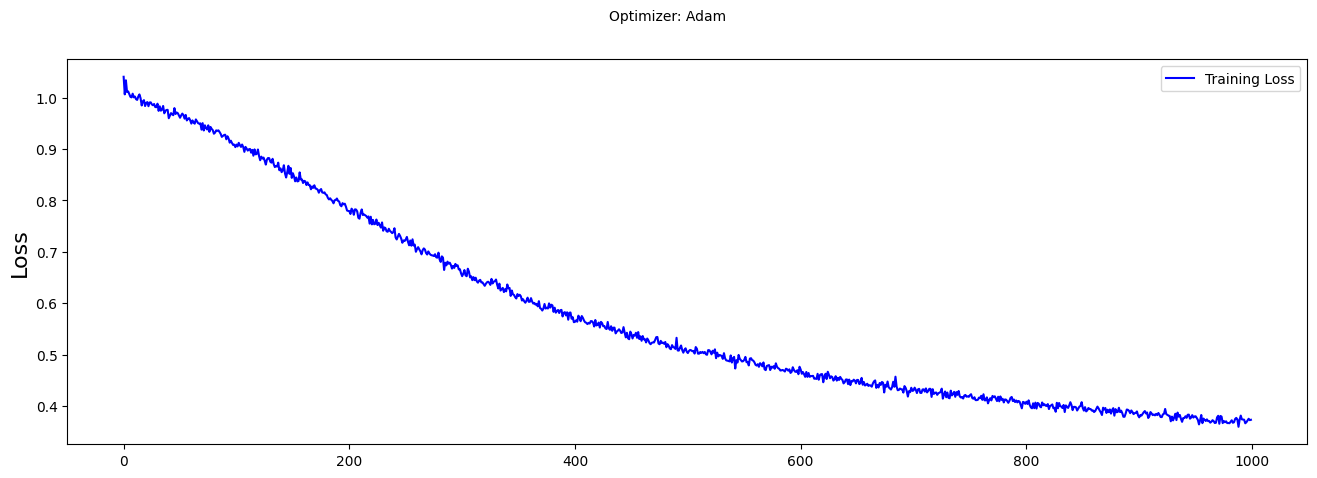

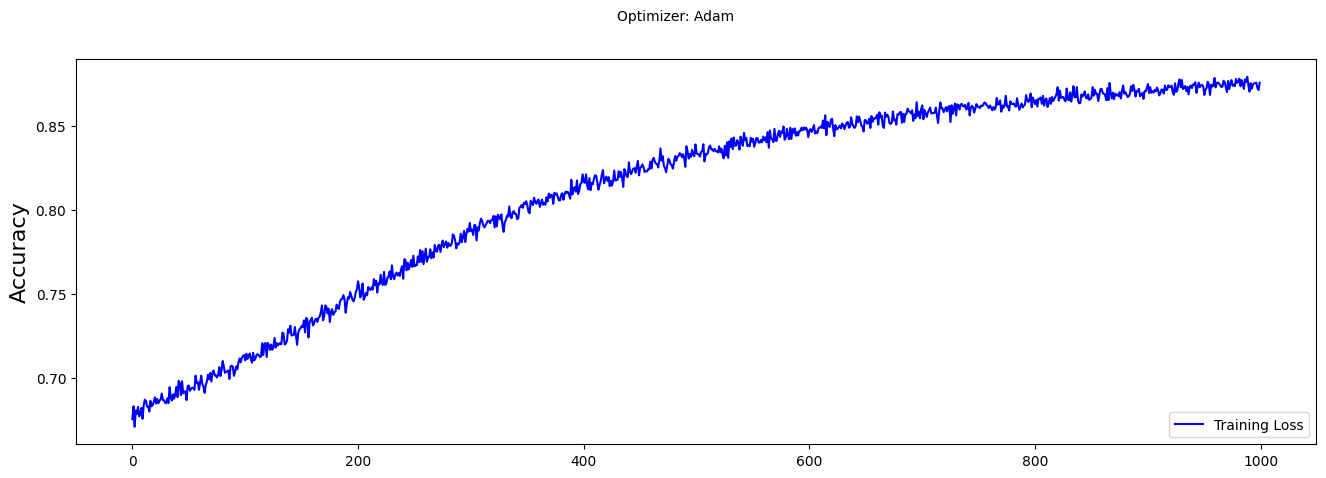

In [ ]:
# loss plot
plt.figure(figsize=(16,5))
plt.subplot(1,1,1)
plt.suptitle('Optimizer: Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], color='b', label='Training Loss')
plt.legend(loc='upper right')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/loss.png')

# acc plot
plt.figure(figsize=(16,5))
plt.subplot(1,1,1)
plt.suptitle('Optimizer: Adam', fontsize=10)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['accuracy'], color='b', label='Training Loss')
plt.legend(loc='lower right')

plt.savefig('/content/drive/MyDrive/Colab Notebooks/acc.png')
plt.show()

## Sample Text
Generate new names by feeding a seed input.

In [ ]:
# samples text from language model
def sample_text(seed_phrase='n', max_length=max_name_len):


    # input x to numerical index
    text_x = to_num_matrix(list(list(seed_phrase)), ch_to_idx)
    # index of current character
    ch = ch_to_idx[seed_phrase]

    # list of predicted character indices
    indices = []
    # counter
    i = 0

    #start generating
    while ch != 0 and i<max_length:
        # predict using the input character
        pred = model.predict(text_x)[0]

        # get the char with highest prob.
        ch = np.random.choice(np.arange(len(vocab_tokens)) , p = pred.ravel())

        if ch!=0:
            indices.append(ch)

        # feed the current char as the next input
        text_x = to_num_matrix(list(list(idx_to_ch[ch])), ch_to_idx)

        i = i+ 1


    return ''.join([idx_to_ch[idx] for idx in indices])

In [ ]:
i = 0
while i < 18:
    name = sample_text(max_length=6)
    if name != '':
        print(name)
        i += 1

1/1 [==============================] - 0s 23ms/step
acasis
1/1 [==============================] - 0s 29ms/step
icefet
1/1 [==============================] - 0s 20ms/step
iflebi
1/1 [==============================] - 0s 24ms/step
iflexa
1/1 [==============================] - 0s 21ms/step
orasys
1/1 [==============================] - 0s 20ms/step
oprosa
1/1 [==============================] - 0s 20ms/step
asatre
1/1 [==============================] - 0s 22ms/step
aprana
1/1 [==============================] - 0s 23ms/step
icolem
1/1 [==============================] - 0s 19ms/step
edoxin
1/1 [==============================] - 0s 21ms/step
alelbo
1/1 [==============================] - 0s 21ms/step
asesat
1/1 [==============================] - 0s 21ms/step
eferar
1/1 [==============================] - 0s 20ms/step
iniana
1/1 [==============================] - 0s 22ms/step
anapis
1/1 [==============================] - 0s 23ms/step
arapru
1/1 [==============================] - 0s 20ms/step
asal